In [1]:
!pip install visualkeras ; 
import visualkeras 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 3.7 MB/s eta 0:00:00a 0:00:01


### Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import imageio
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns #visualization 
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


### Set seed for reproducibility

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load and process data

In [5]:
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.fashion_mnist.load_data()  ; #from zalando 
X = np.concatenate([X_train_val,X_test],axis=0)
X = np.expand_dims(((X-127.5)/127.5),axis=-1).astype('float32') #-1, 1 normalization 
# we have an hyperbolic tangent as output (-1, 1)
y = np.concatenate([y_train_val,y_test],axis=0)
X.shape, y.shape

# there is no technique to evaluate GAN, understanding if if overfits is difficult 
# IDEA: more training means more information means more generation  

4431872/4422102 [==============================] - 0s 0us/step


((70000, 28, 28, 1), (70000,))

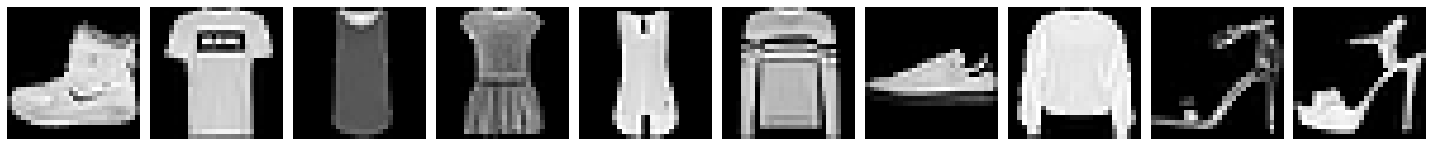

In [6]:
# Inspect the data
fig, axes = plt.subplots(1, 10, figsize=(20,10))
for i in range(10):
    ax = axes[i%10]
    ax.imshow(np.squeeze(X[i]), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
print('Data shape', X.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X.min(), X.max(), X.mean(), X.std()))
# TRADE OFF between bounds (fixed) vs good mean, stdv

Data shape (70000, 28, 28, 1)
Data min -1.00
Data max 1.00
Data mean -0.43
Data std 0.71


In [8]:
input_shape = X.shape[1:]
input_shape

(28, 28, 1)

### Vanilla Generative Adversarial Network

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
padding (ZeroPadding2D)      (None, 32, 32, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
activation1 (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 8, 128)         73856     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 8, 8, 128)       

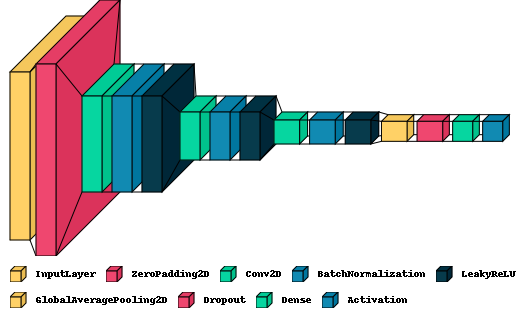

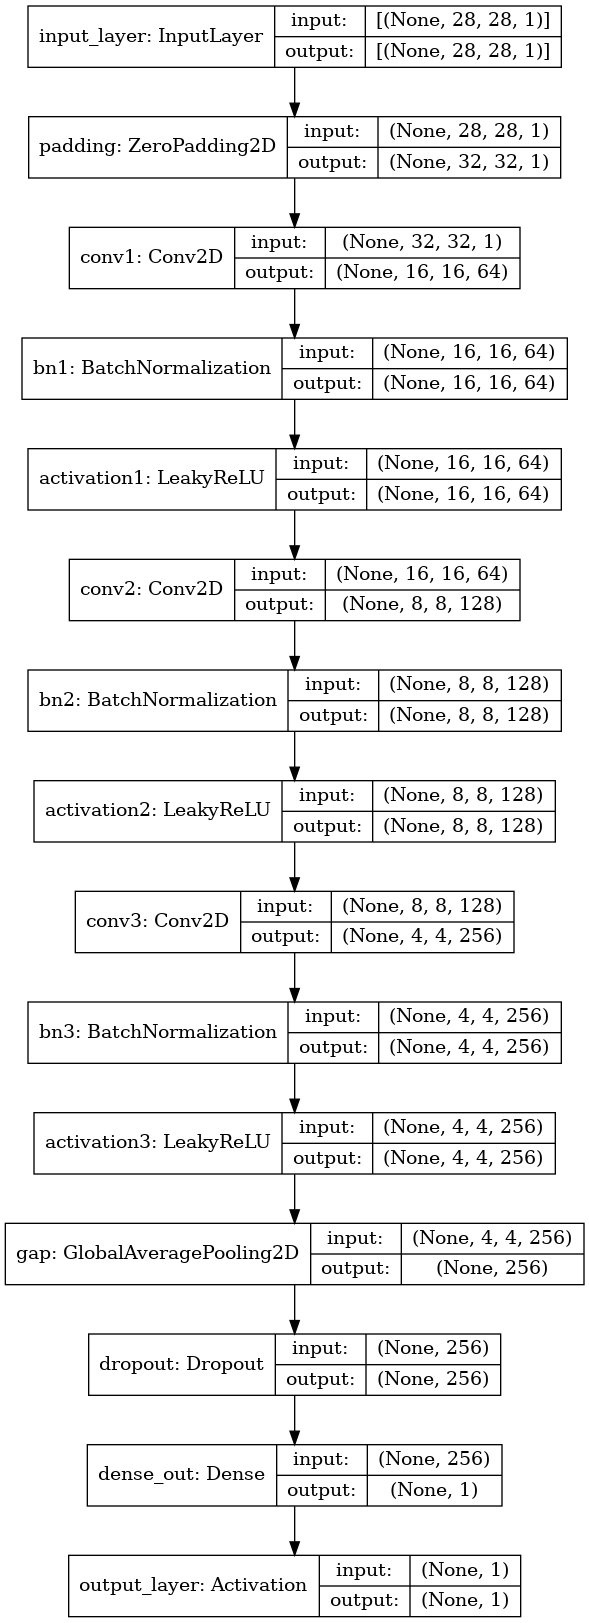

In [9]:
def get_dc_discriminator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the discriminator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.ZeroPadding2D((2,2), name='padding')(input_layer) #for commodity because of dimension (we want to work with 32x32) but pics in input are 28x28

    x = tfkl.Conv2D(64, 3, padding='same', strides=2, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dropout(.5, seed=seed, name='dropout')(x)
    x = tfkl.Dense(1, name='dense_out')(x)
    output_layer = tfkl.Activation('sigmoid', name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='discriminator')
    #NW: model is not compiled, we have no loss,no metrics etc 
    # Return the discriminator
    return model
discriminator = get_dc_discriminator(input_shape)
discriminator.summary()
display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='vanilla_discriminator.png')

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128)]             0         
_________________________________________________________________
dense0 (Dense)               (None, 1024)              131072    
_________________________________________________________________
bn0 (BatchNormalization)     (None, 1024)              4096      
_________________________________________________________________
activation0 (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
upsampling1 (UpSampling2D)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 8, 8, 64)          36

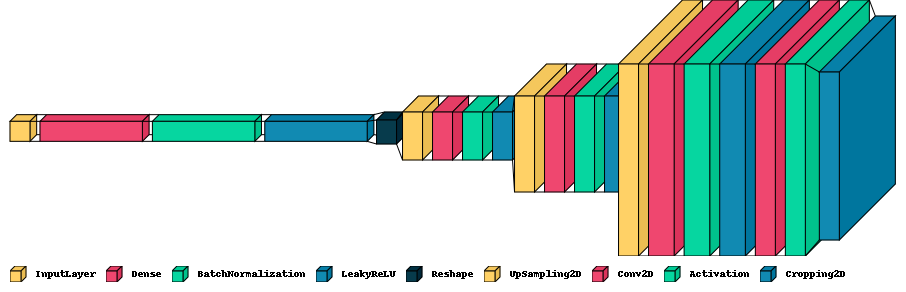

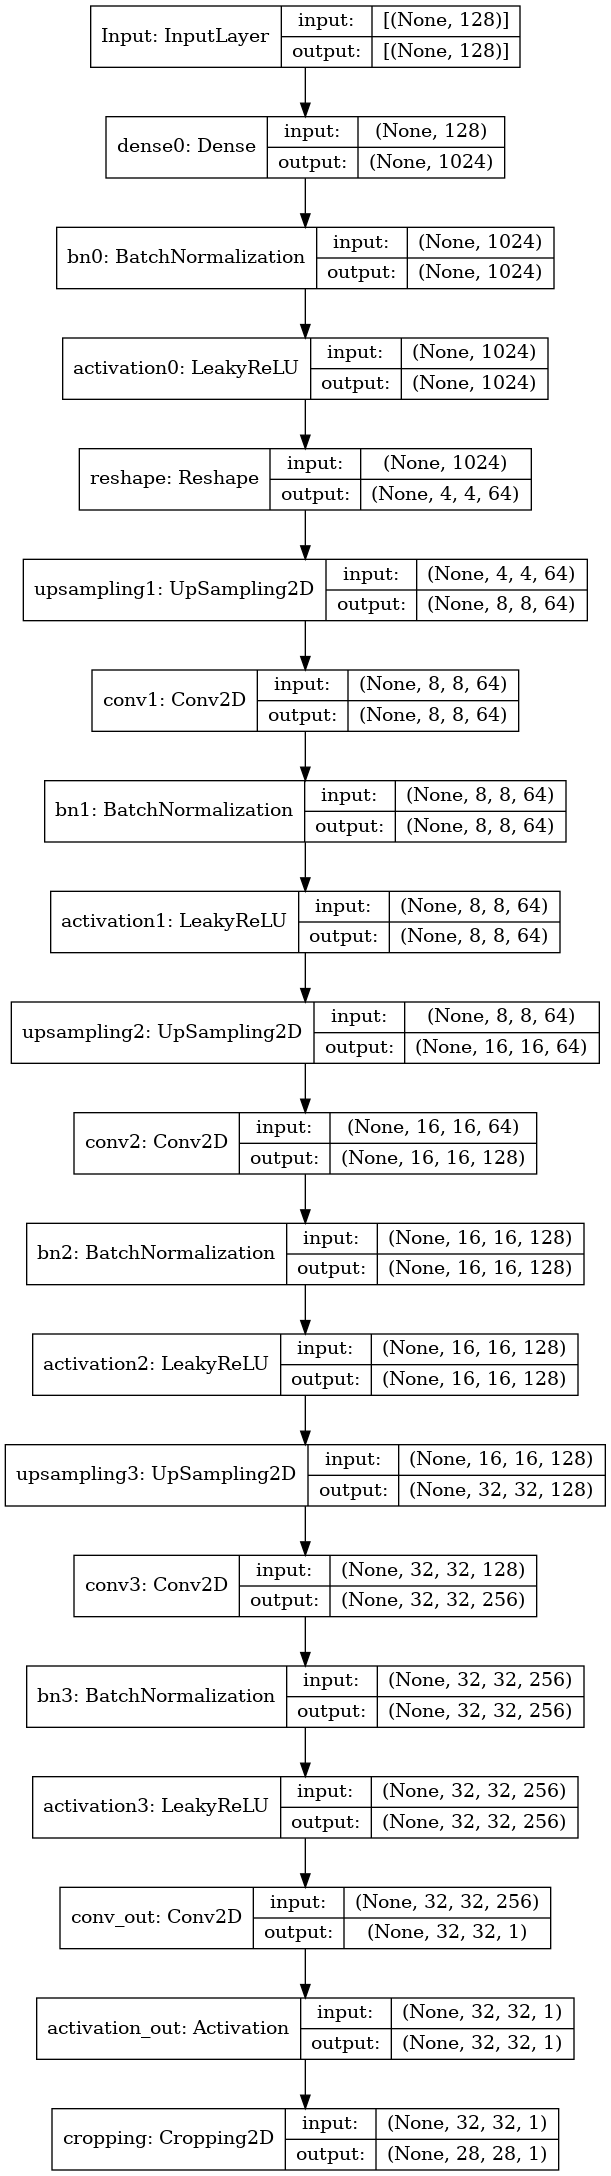

In [10]:
latent_dim = 128 #tunable, dimension of the input of the generator 
'''
The generator receives as input noise (128vector), it has to learn to generate samples belonging to the training set distribution. 
''' 

def get_dc_generator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the generator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Dense(4*4*64, use_bias=False, name='dense0')(input_layer)
    x = tfkl.BatchNormalization(name='bn0')(x)
    x = tfkl.LeakyReLU(alpha=0.1, name='activation0')(x)
    x = tfkl.Reshape((4,4,64))(x) #to make it working with conv 

    x = tfkl.UpSampling2D(name='upsampling1')(x)
    x = tfkl.Conv2D(64, 3, padding='same', use_bias=False, name='conv1')(x) # use_bias -> we remove the sum  (not mandatory) because 
    # we want to force generator to follow exactly the distribution in input, do not move y asix of each dimension 
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.1, name='activation1')(x)

    x = tfkl.UpSampling2D(name='upsampling2')(x)
    x = tfkl.Conv2D(128, 3, padding='same', use_bias=False, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.1, name='activation2')(x)

    x = tfkl.UpSampling2D(name='upsampling3')(x)
    x = tfkl.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.1, name='activation3')(x)

    x = tfkl.Conv2D(1, 3, padding='same', use_bias=False, name='conv_out')(x)
    x = tfkl.Activation('tanh', name='activation_out')(x) # bound the output in the range -1, 1 
    output_layer = tfkl.Cropping2D((2,2), name='cropping')(x) # 28 x 28 output (not 32 x 32)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='generator')

    # Return the model
    return model
generator = get_dc_generator(latent_dim)
generator.summary()
display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='vanilla_generator.png')

Now we check data flow, gradients computations, how the net is updated. 

In [11]:
'''
We particularize the class tfk.Model 
'''

class GAN(tfk.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.loss_tracker = tfk.metrics.Mean(name="loss") #GAN 
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss") # Discriminator
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss") # we want to take the mean of this metrics 

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]
    # here labels are not used !
    @tf.function
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0] # from here on we work in the batch dimension 
        z = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images from z
        generated_images = self.generator(z)

        # Combine generated images and real ones
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Create labels so that fake images correspond to class 0 and real images to class 1
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
        

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(labels, predictions)) # for each sample we only want one update
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights)) # the gradient will only we computed wrt to these w 

        loss = d_loss

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Create misleading labels for fake images so that they correspond to class 1
        misleading_labels = tf.ones((batch_size, 1)) #ZERO SUM GAME 
        # this row is the core of the model as we label as real images generated from fake dist

        # Train the generator 
        with tf.GradientTape() as tape: # apply operations in the scope 
            misleading_predictions = self.discriminator(self.generator(z)) #here we put generator inside as we want to update it
            # we want to MAXIMIZE the error of the discriminator, so we say the data is real but in reality we are using the generator 
            # to generate it 
            g_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(misleading_labels, misleading_predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        loss += g_loss #just to know what global loss is like, in general d_loss and g_loss are enough 

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "loss": self.loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [12]:
class GANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray

    def on_epoch_end(self, epoch, logs=None):
        tf.random.set_seed(seed)
        os.makedirs(self.name+'temp', exist_ok=True)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors).numpy()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20,self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i%self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')
        fig.savefig(self.name+'temp/'+'{:0>5}'.format(epoch)+'.png') 
        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
        fp_in = self.name+"temp/*.png"
        fp_out = self.name+"_generated_images.gif"
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, optimize=False)    
        shutil.rmtree(self.name+"temp")

In [13]:
epochs = 100
learning_rate = 5e-5 #GOLDEN RULE : no convergence? reduce the learning rate 
batch_size = 128

In [14]:
gan = GAN(
    discriminator = get_dc_discriminator(input_shape), 
    generator = get_dc_generator(latent_dim), 
    latent_dim = latent_dim
)
gan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
)

In [15]:
'''
fixed to have always the same noise, by default as you want to see same 
image every time -> do not change the noise in input 
'''
def sample(model, num_img, latent_dim, fixed=True, gray=False):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = model(z).numpy()

    fig, axes = plt.subplots(1, num_img, figsize=(20,num_img))
    for i in range(num_img):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i%num_img]
        if gray:
            ax.imshow(np.squeeze(img), cmap='gray')
        else:
            ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def generate_dataset(model, num_img, latent_dim, fixed=True):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = model(z).numpy()
    return generated_images

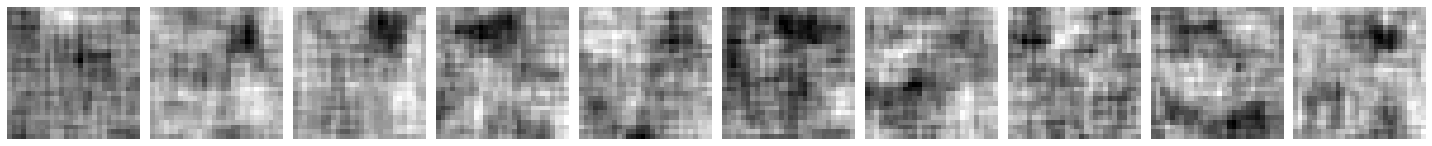

In [16]:
sample(gan.generator, 10, latent_dim, fixed=False, gray=True)

Epoch 1/100
547/547 - 25s - loss: 1.4301 - d_loss: 0.6630 - g_loss: 0.7671


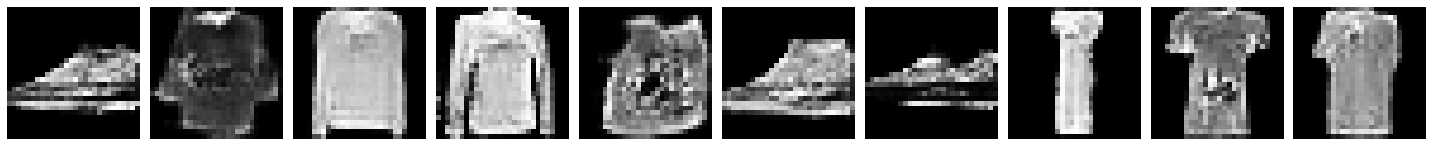

Epoch 2/100
547/547 - 25s - loss: 1.4414 - d_loss: 0.6621 - g_loss: 0.7794


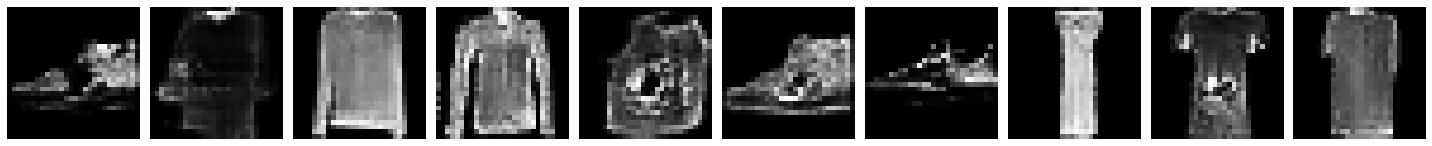

Epoch 3/100
547/547 - 25s - loss: 1.4637 - d_loss: 0.6589 - g_loss: 0.8048


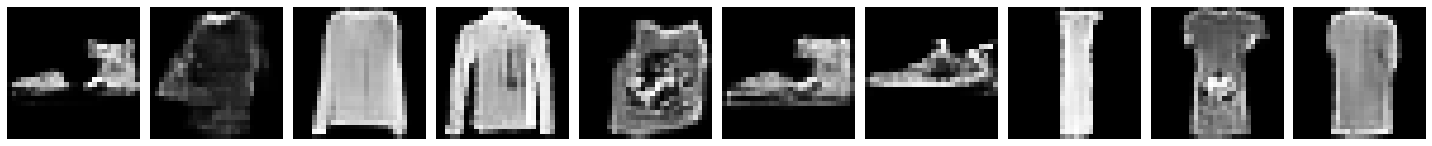

Epoch 4/100
547/547 - 25s - loss: 1.4297 - d_loss: 0.6608 - g_loss: 0.7689


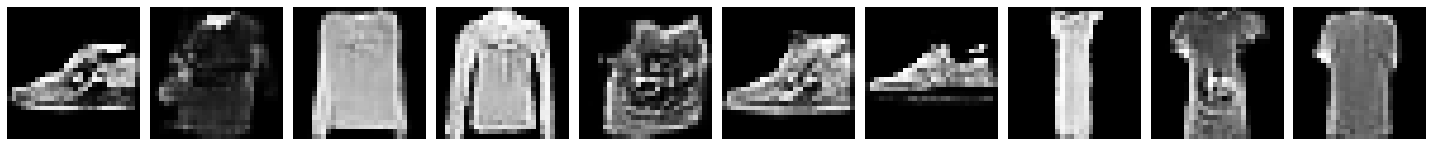

Epoch 5/100
547/547 - 25s - loss: 1.4376 - d_loss: 0.6604 - g_loss: 0.7771


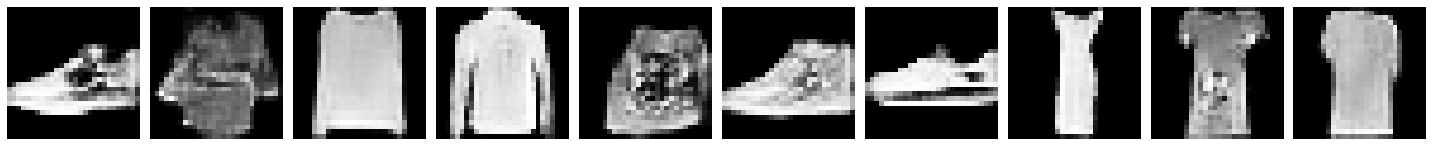

Epoch 6/100
547/547 - 25s - loss: 1.4520 - d_loss: 0.6582 - g_loss: 0.7938


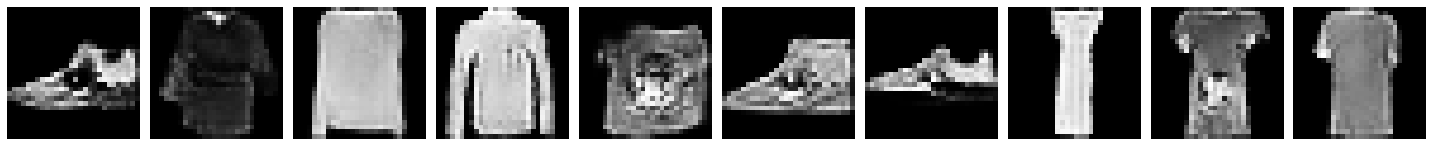

Epoch 7/100
547/547 - 25s - loss: 1.4145 - d_loss: 0.6658 - g_loss: 0.7487


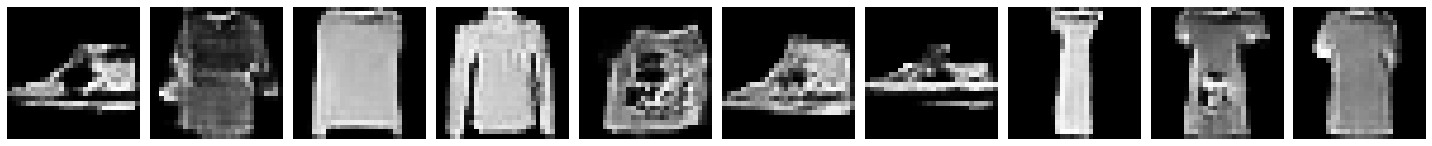

Epoch 8/100
547/547 - 25s - loss: 1.4454 - d_loss: 0.6561 - g_loss: 0.7894


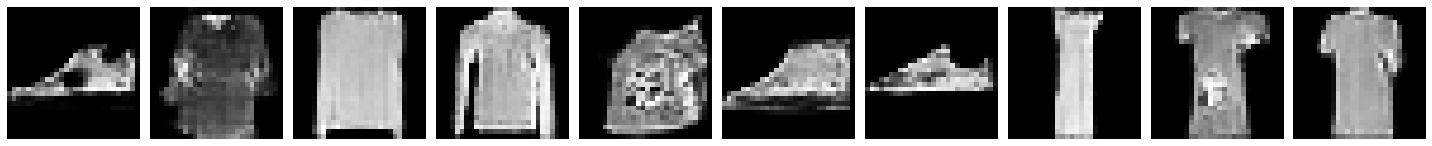

Epoch 9/100
547/547 - 25s - loss: 1.4651 - d_loss: 0.6597 - g_loss: 0.8054


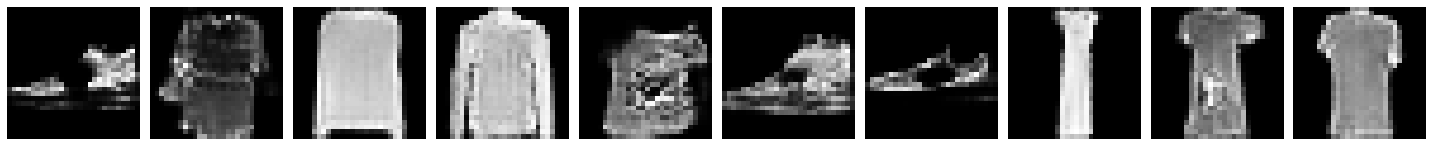

Epoch 10/100
547/547 - 25s - loss: 1.4242 - d_loss: 0.6657 - g_loss: 0.7586


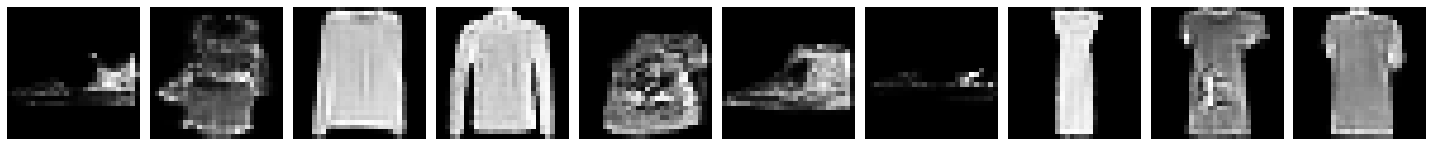

Epoch 11/100
547/547 - 25s - loss: 1.4322 - d_loss: 0.6599 - g_loss: 0.7723


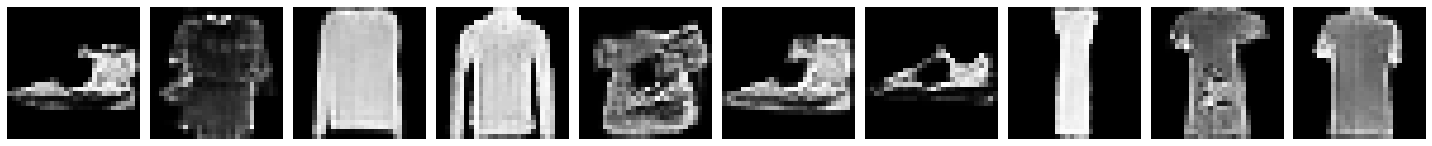

Epoch 12/100
547/547 - 25s - loss: 1.4246 - d_loss: 0.6623 - g_loss: 0.7623


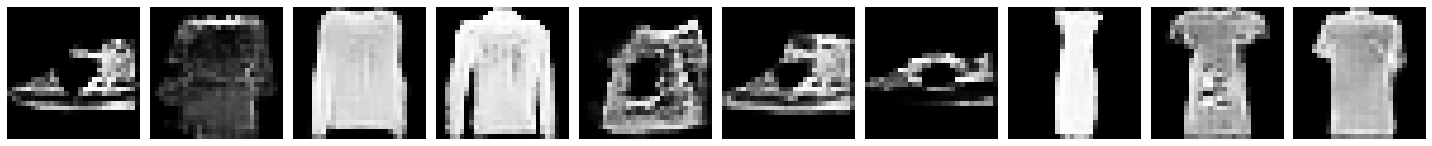

Epoch 13/100
547/547 - 25s - loss: 1.4622 - d_loss: 0.6557 - g_loss: 0.8065


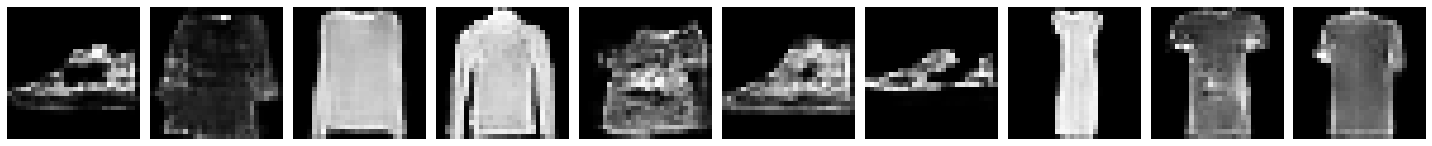

Epoch 14/100
547/547 - 25s - loss: 1.4214 - d_loss: 0.6598 - g_loss: 0.7615


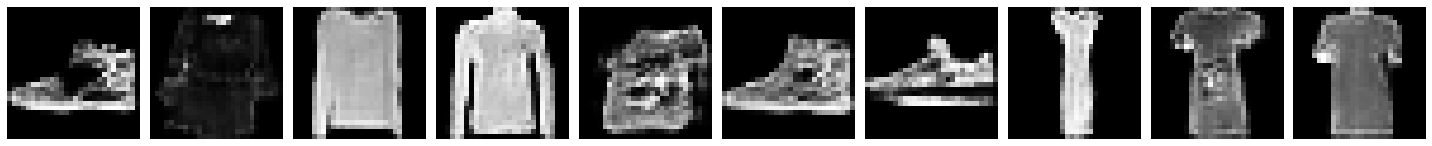

Epoch 15/100
547/547 - 25s - loss: 1.4695 - d_loss: 0.6543 - g_loss: 0.8152


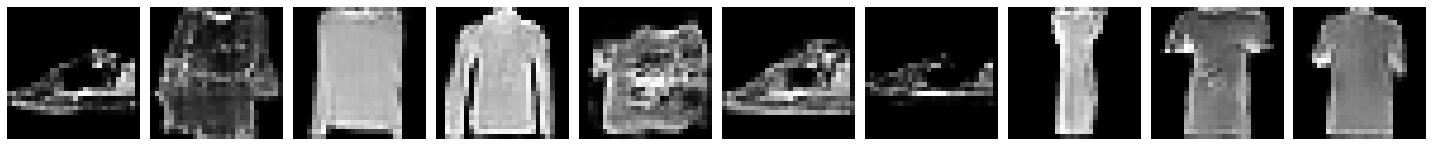

Epoch 16/100
547/547 - 25s - loss: 1.4268 - d_loss: 0.6601 - g_loss: 0.7666


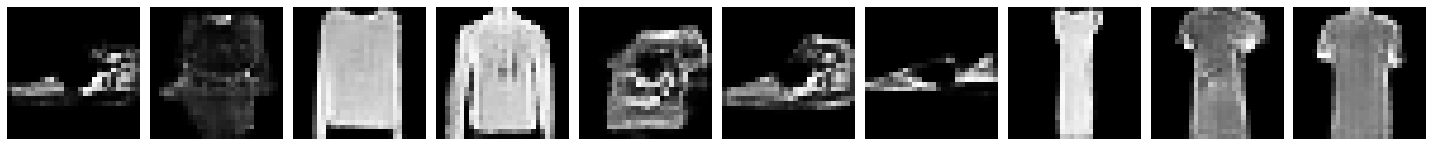

Epoch 17/100
547/547 - 25s - loss: 1.4295 - d_loss: 0.6594 - g_loss: 0.7701


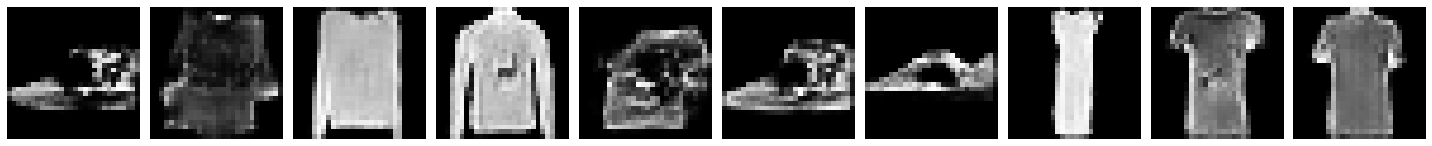

Epoch 18/100
547/547 - 25s - loss: 1.4165 - d_loss: 0.6653 - g_loss: 0.7512


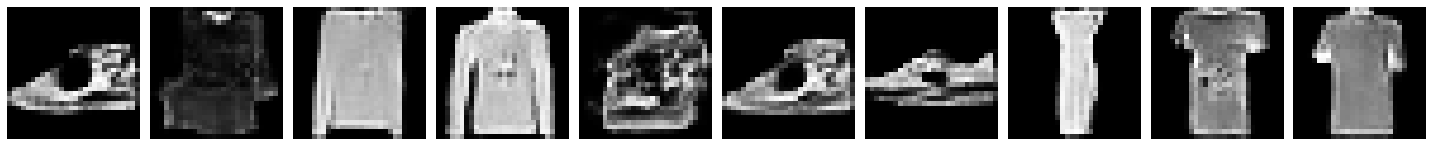

Epoch 19/100
547/547 - 25s - loss: 1.4248 - d_loss: 0.6622 - g_loss: 0.7627


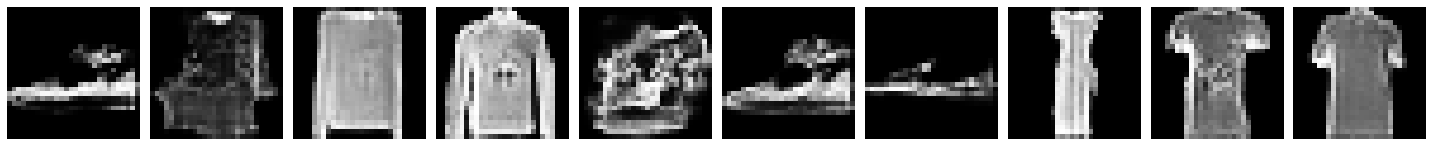

Epoch 20/100
547/547 - 25s - loss: 1.4666 - d_loss: 0.6587 - g_loss: 0.8079


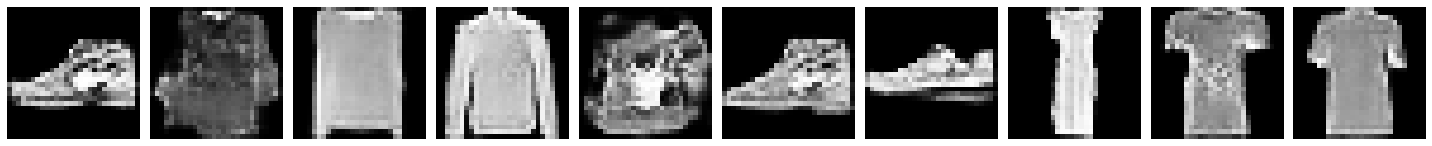

Epoch 21/100
547/547 - 25s - loss: 1.4375 - d_loss: 0.6587 - g_loss: 0.7789


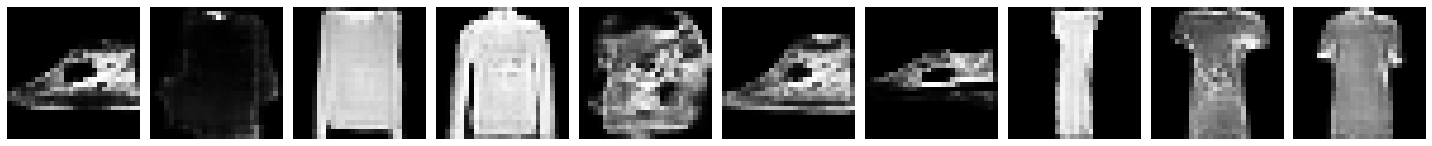

Epoch 22/100
547/547 - 25s - loss: 1.4275 - d_loss: 0.6583 - g_loss: 0.7693


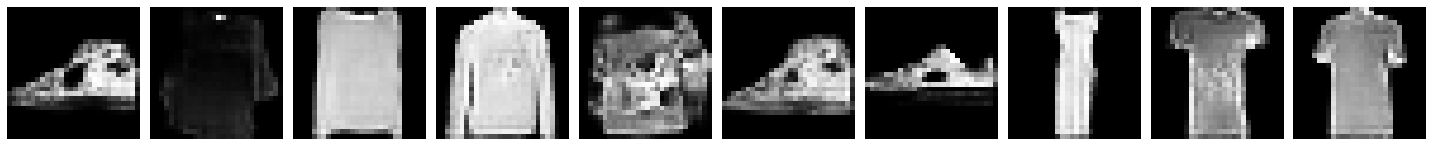

Epoch 23/100
547/547 - 25s - loss: 1.4342 - d_loss: 0.6605 - g_loss: 0.7736


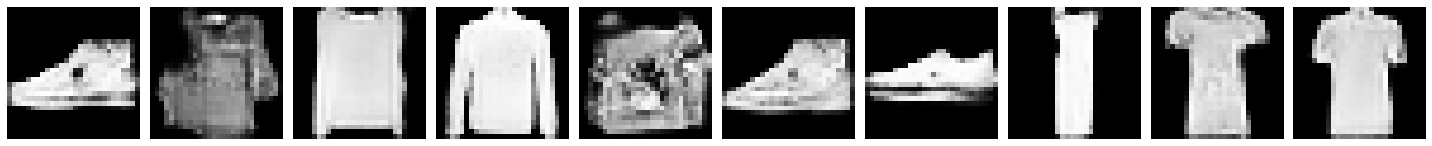

Epoch 24/100
547/547 - 25s - loss: 1.4765 - d_loss: 0.6510 - g_loss: 0.8255


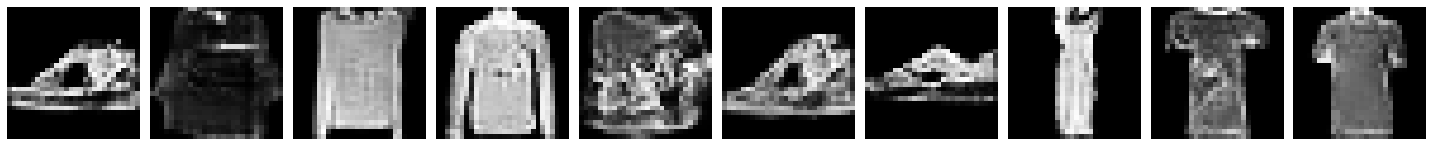

Epoch 25/100
547/547 - 25s - loss: 1.4098 - d_loss: 0.6608 - g_loss: 0.7489


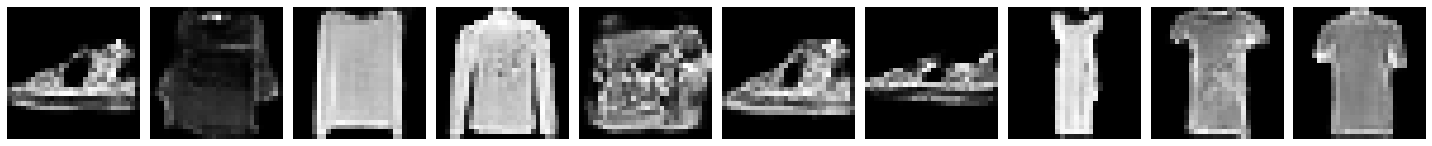

Epoch 26/100
547/547 - 25s - loss: 1.4271 - d_loss: 0.6617 - g_loss: 0.7655


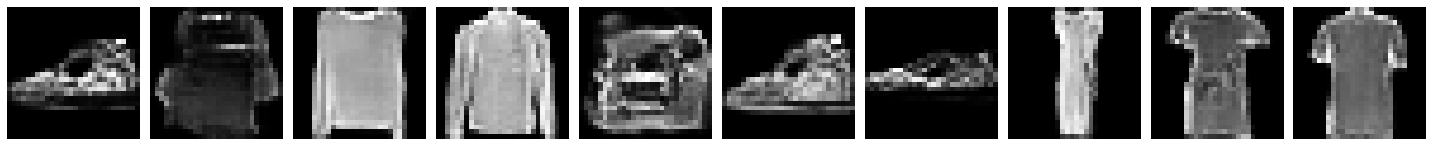

Epoch 27/100
547/547 - 25s - loss: 1.4465 - d_loss: 0.6565 - g_loss: 0.7900


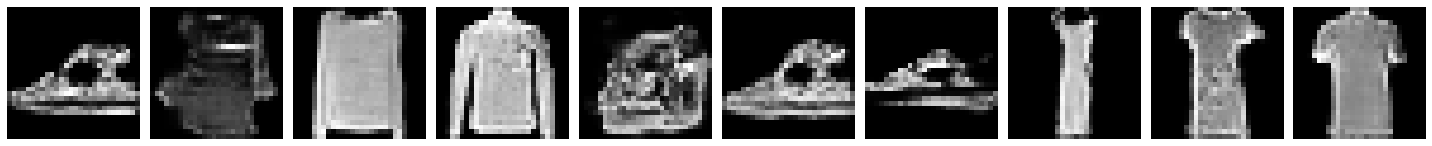

Epoch 28/100
547/547 - 25s - loss: 1.4148 - d_loss: 0.6623 - g_loss: 0.7525


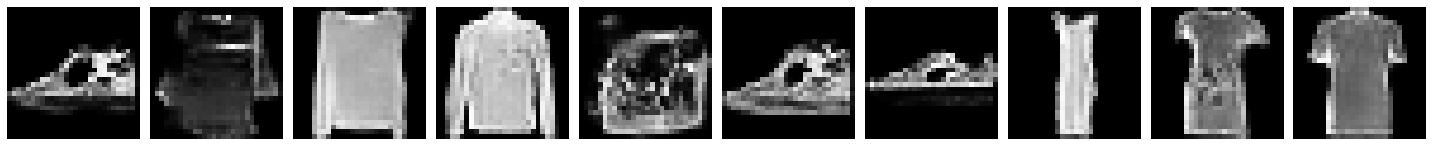

Epoch 29/100
547/547 - 25s - loss: 1.4211 - d_loss: 0.6642 - g_loss: 0.7569


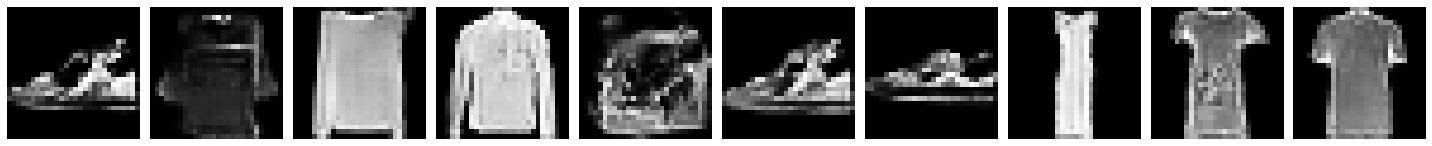

Epoch 30/100
547/547 - 25s - loss: 1.4392 - d_loss: 0.6633 - g_loss: 0.7759


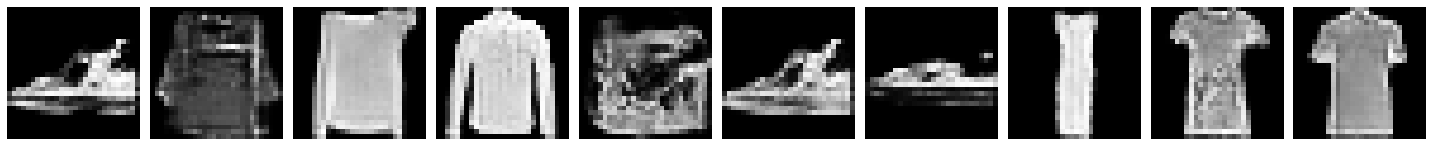

Epoch 31/100
547/547 - 25s - loss: 1.4280 - d_loss: 0.6623 - g_loss: 0.7657


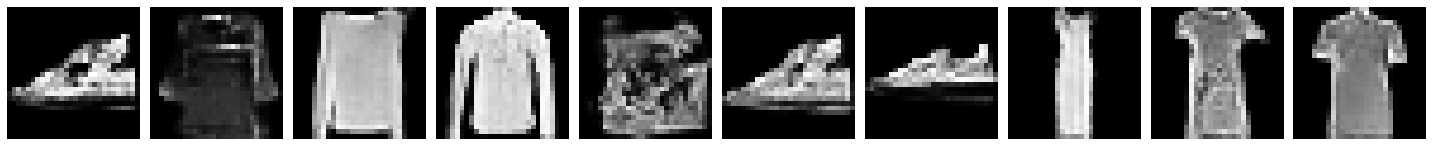

Epoch 32/100
547/547 - 25s - loss: 1.4231 - d_loss: 0.6621 - g_loss: 0.7610


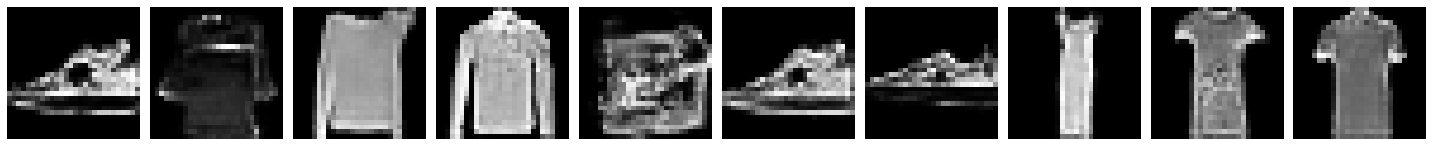

Epoch 33/100
547/547 - 25s - loss: 1.4208 - d_loss: 0.6619 - g_loss: 0.7589


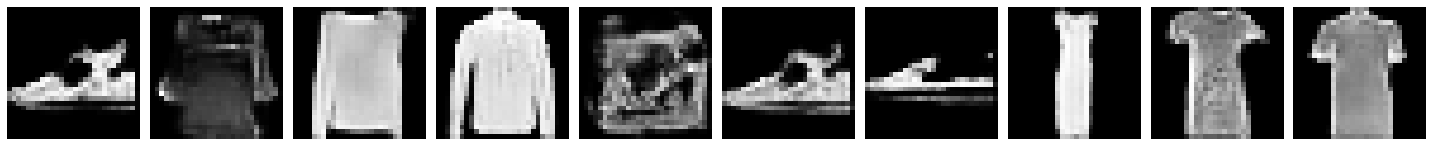

Epoch 34/100
547/547 - 25s - loss: 1.4182 - d_loss: 0.6637 - g_loss: 0.7545


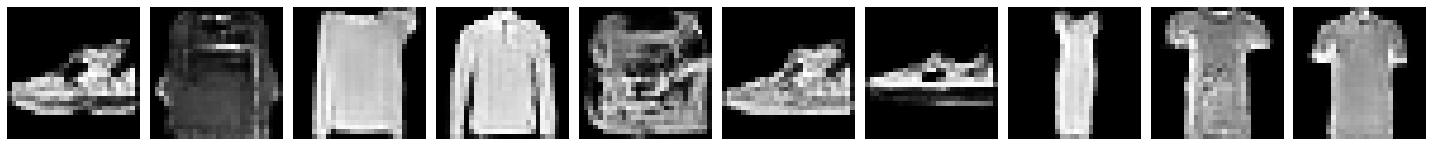

Epoch 35/100
547/547 - 25s - loss: 1.4547 - d_loss: 0.6588 - g_loss: 0.7960


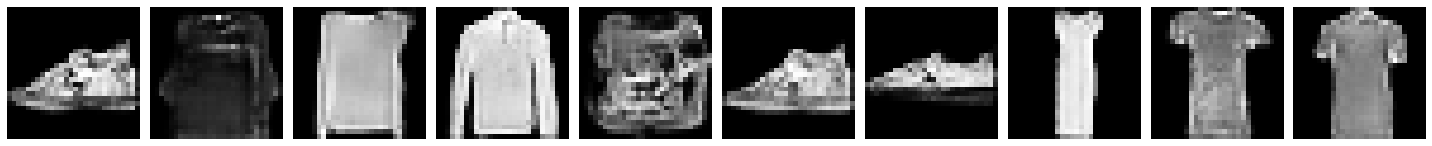

Epoch 36/100
547/547 - 25s - loss: 1.4161 - d_loss: 0.6613 - g_loss: 0.7549


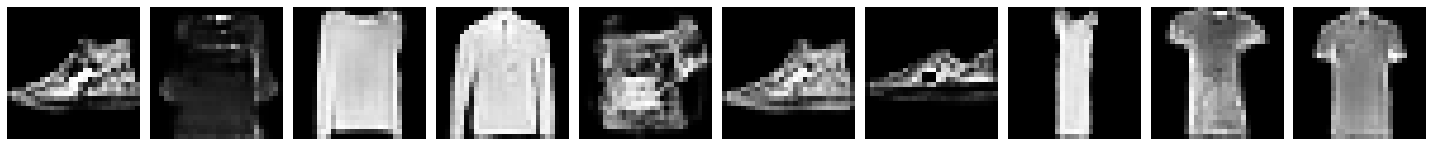

Epoch 37/100
547/547 - 25s - loss: 1.4202 - d_loss: 0.6606 - g_loss: 0.7596


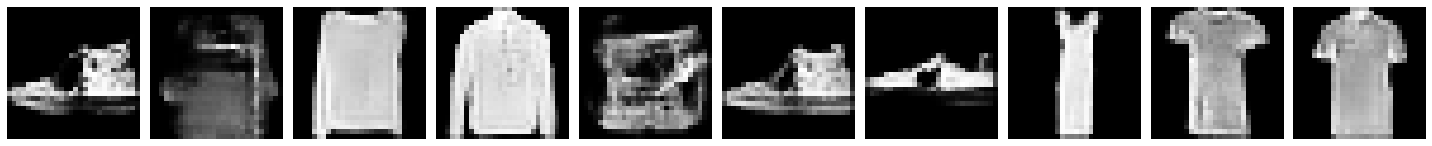

Epoch 38/100
547/547 - 25s - loss: 1.4599 - d_loss: 0.6552 - g_loss: 0.8048


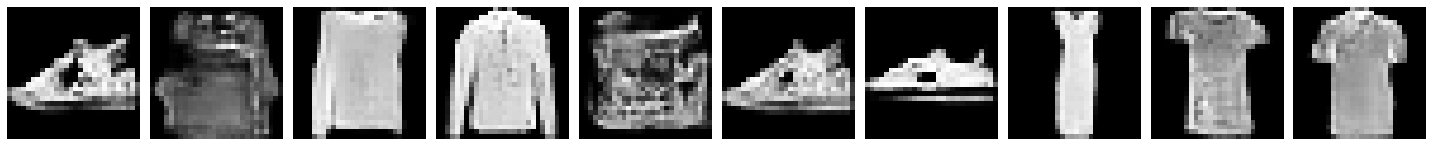

Epoch 39/100
547/547 - 25s - loss: 1.4319 - d_loss: 0.6629 - g_loss: 0.7690


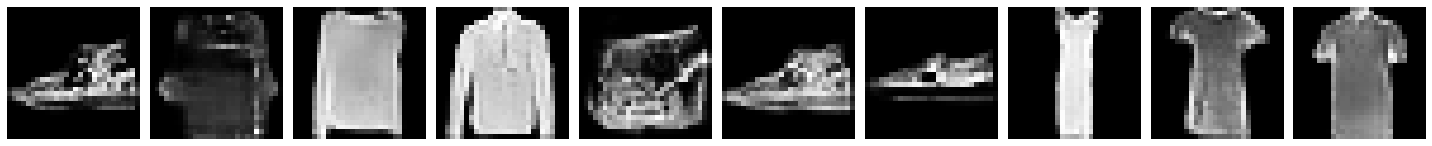

Epoch 40/100
547/547 - 25s - loss: 1.4011 - d_loss: 0.6619 - g_loss: 0.7392


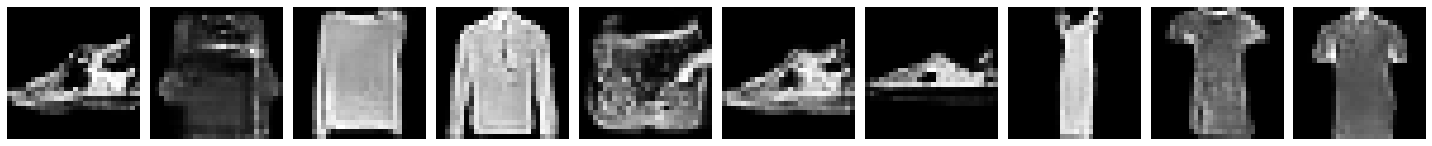

Epoch 41/100
547/547 - 25s - loss: 1.4090 - d_loss: 0.6612 - g_loss: 0.7478


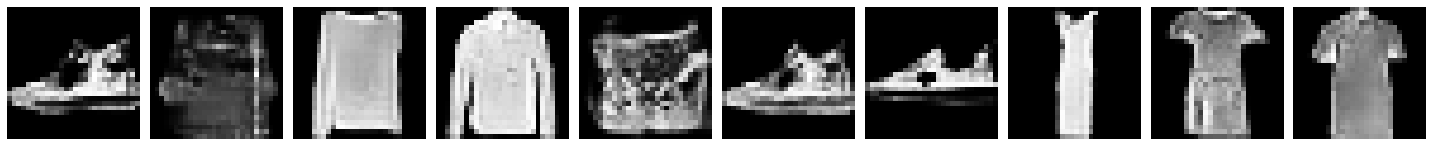

Epoch 42/100
547/547 - 25s - loss: 1.4948 - d_loss: 0.6583 - g_loss: 0.8365


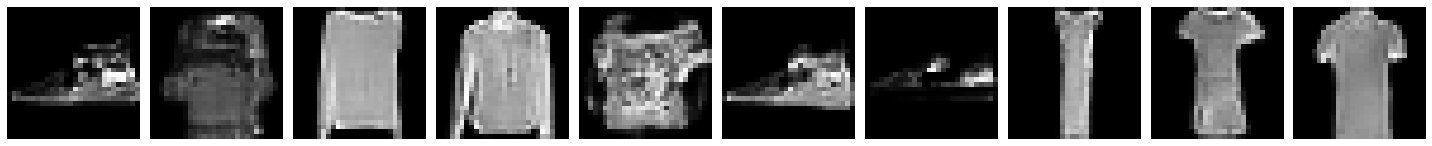

Epoch 43/100
547/547 - 25s - loss: 1.4244 - d_loss: 0.6610 - g_loss: 0.7634


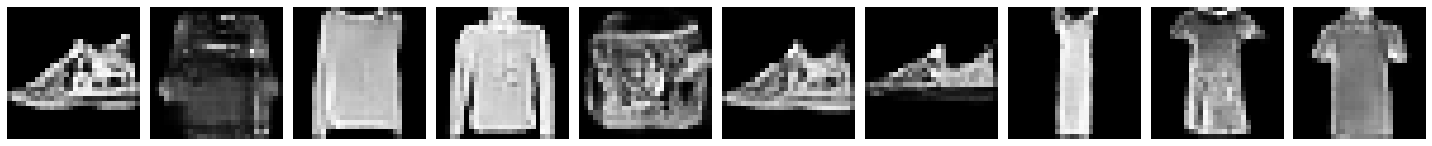

Epoch 44/100
547/547 - 25s - loss: 1.4141 - d_loss: 0.6602 - g_loss: 0.7539


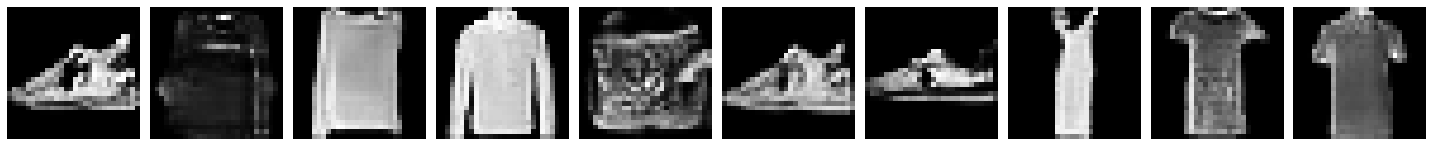

Epoch 45/100
547/547 - 25s - loss: 1.4246 - d_loss: 0.6625 - g_loss: 0.7621


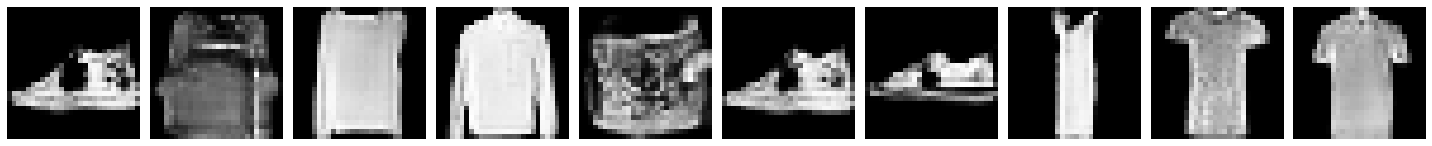

Epoch 46/100
547/547 - 25s - loss: 1.4514 - d_loss: 0.6589 - g_loss: 0.7925


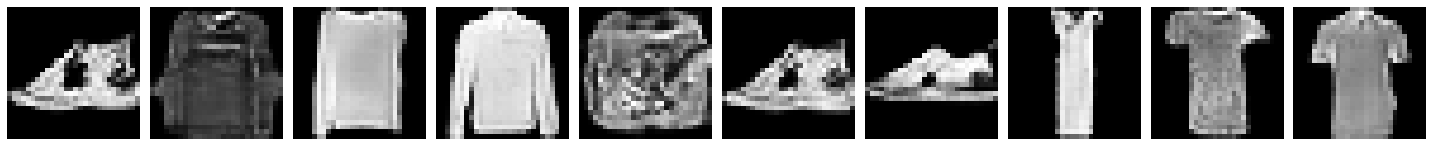

Epoch 47/100
547/547 - 25s - loss: 1.4149 - d_loss: 0.6620 - g_loss: 0.7529


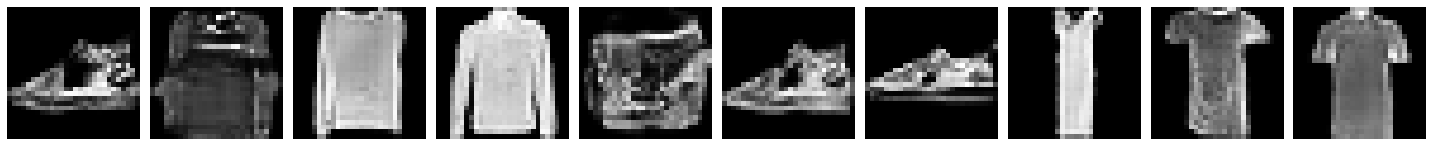

Epoch 48/100
547/547 - 25s - loss: 1.4006 - d_loss: 0.6627 - g_loss: 0.7379


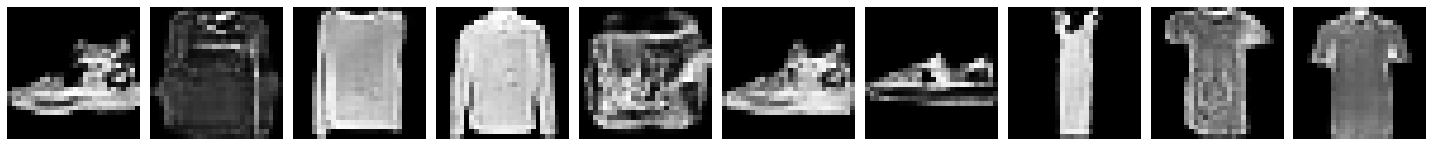

Epoch 49/100
547/547 - 25s - loss: 1.4199 - d_loss: 0.6629 - g_loss: 0.7570


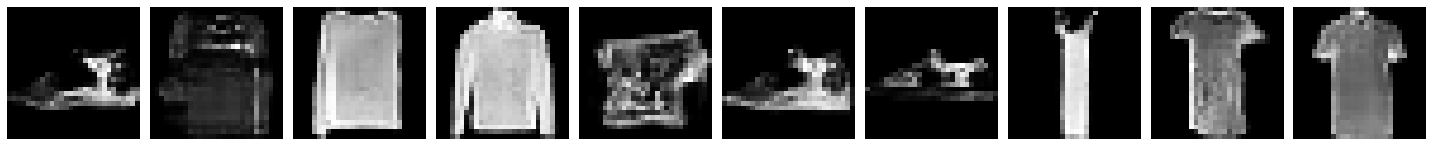

Epoch 50/100
547/547 - 25s - loss: 1.4831 - d_loss: 0.6519 - g_loss: 0.8312


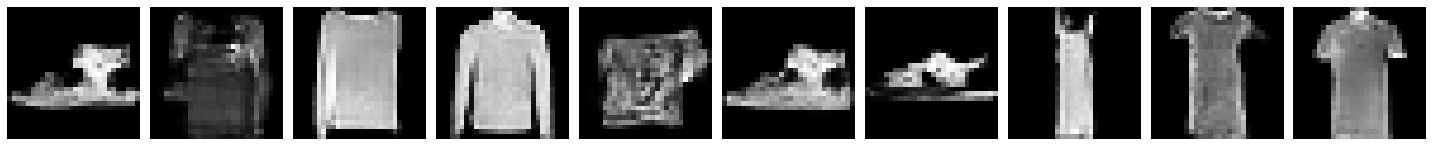

Epoch 51/100
547/547 - 25s - loss: 1.4189 - d_loss: 0.6612 - g_loss: 0.7578


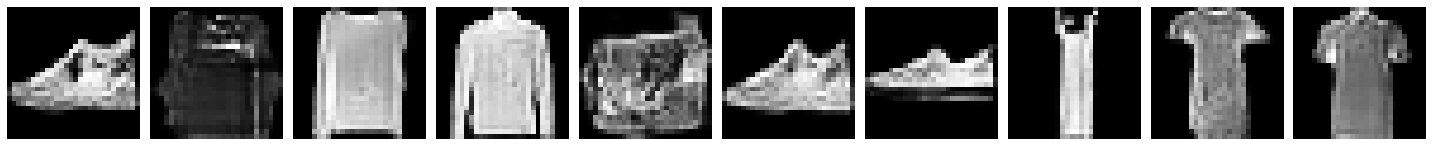

Epoch 52/100
547/547 - 25s - loss: 1.4133 - d_loss: 0.6616 - g_loss: 0.7517


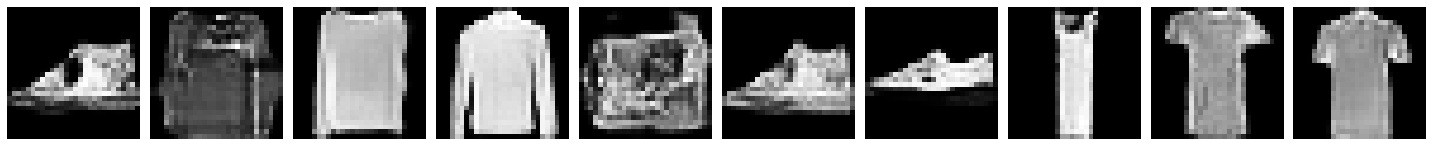

Epoch 53/100
547/547 - 25s - loss: 1.4441 - d_loss: 0.6594 - g_loss: 0.7848


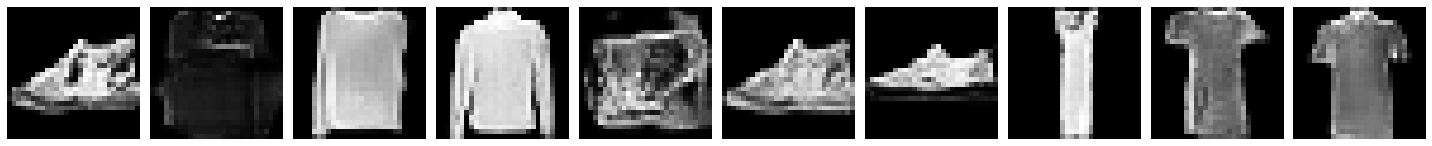

Epoch 54/100
547/547 - 25s - loss: 1.4108 - d_loss: 0.6624 - g_loss: 0.7484


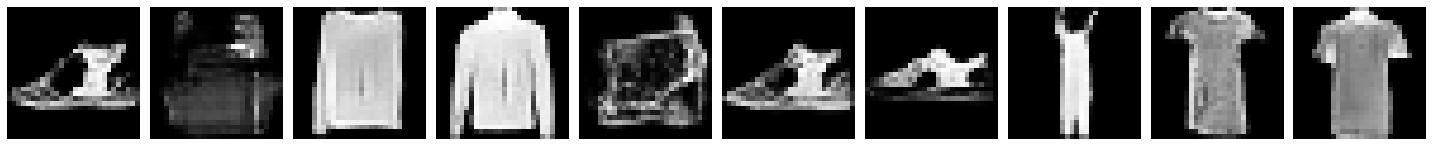

Epoch 55/100
547/547 - 25s - loss: 1.4221 - d_loss: 0.6620 - g_loss: 0.7601


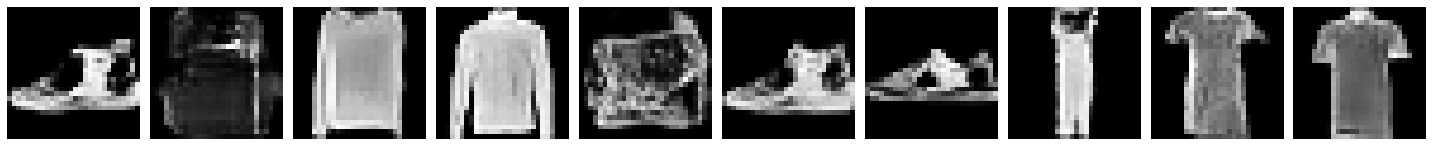

Epoch 56/100
547/547 - 25s - loss: 1.4207 - d_loss: 0.6636 - g_loss: 0.7571


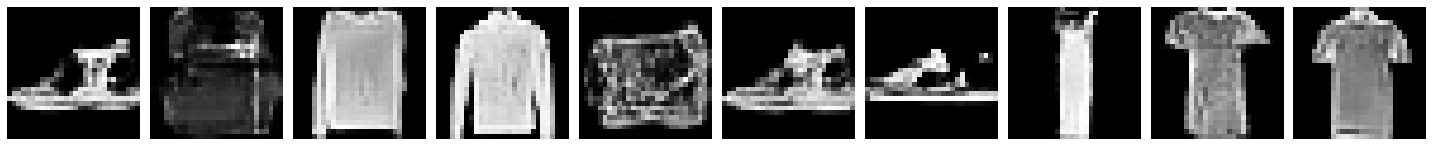

Epoch 57/100
547/547 - 25s - loss: 1.4674 - d_loss: 0.6564 - g_loss: 0.8110


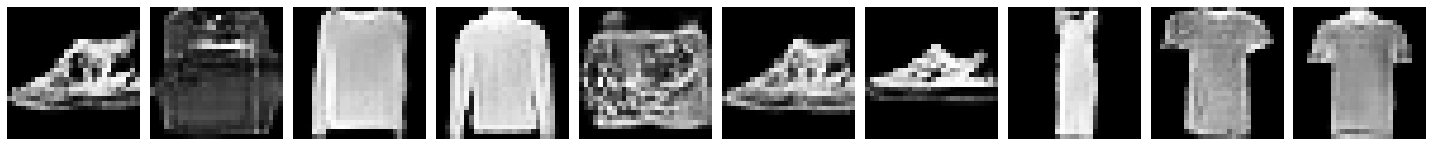

Epoch 58/100
547/547 - 25s - loss: 1.4125 - d_loss: 0.6638 - g_loss: 0.7487


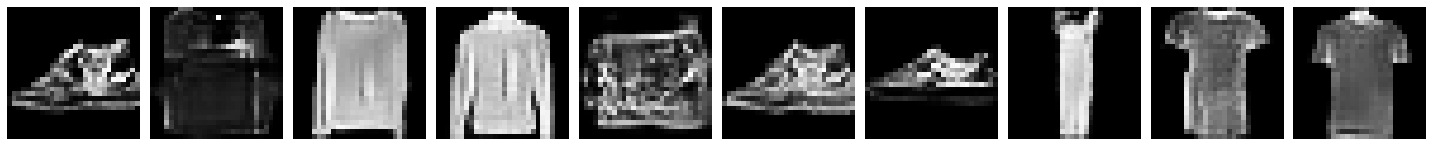

Epoch 59/100
547/547 - 25s - loss: 1.4065 - d_loss: 0.6624 - g_loss: 0.7442


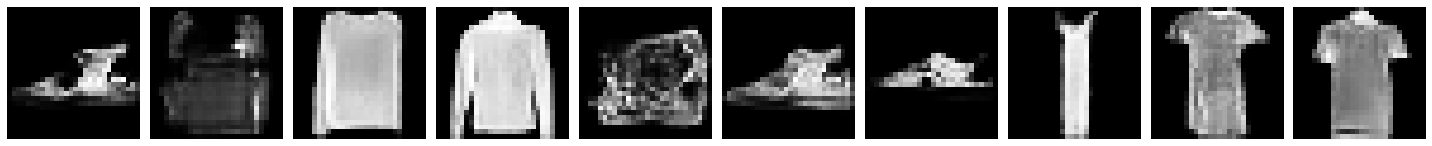

Epoch 60/100
547/547 - 25s - loss: 1.4423 - d_loss: 0.6626 - g_loss: 0.7797


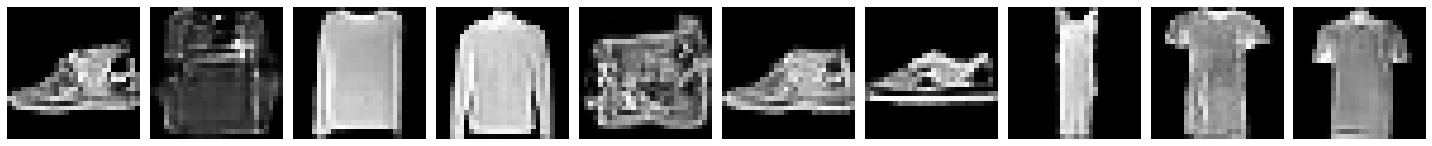

Epoch 61/100
547/547 - 25s - loss: 1.4565 - d_loss: 0.6590 - g_loss: 0.7975


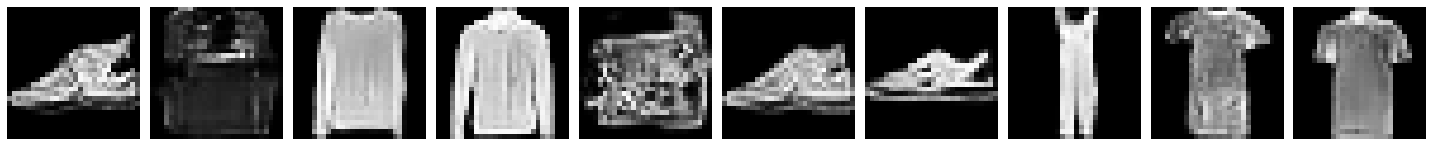

Epoch 62/100
547/547 - 25s - loss: 1.3988 - d_loss: 0.6633 - g_loss: 0.7355


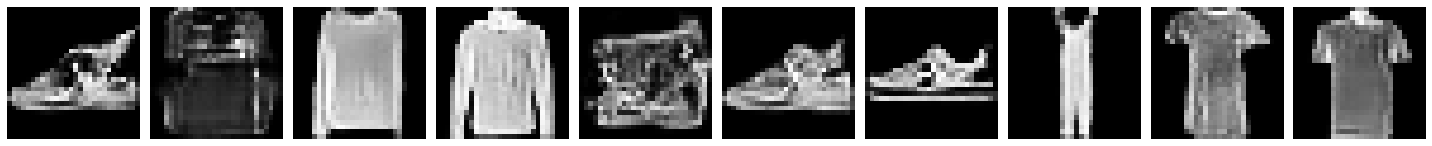

Epoch 63/100
547/547 - 25s - loss: 1.4411 - d_loss: 0.6596 - g_loss: 0.7815


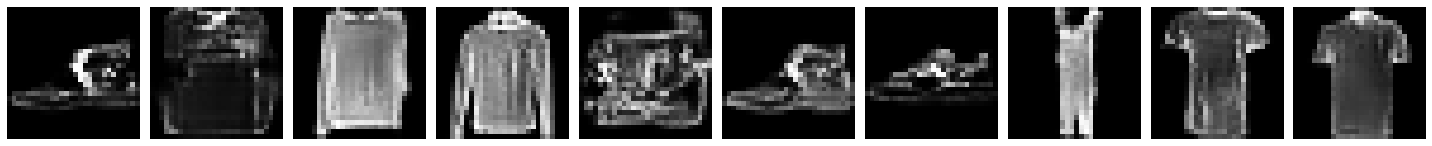

Epoch 64/100
547/547 - 25s - loss: 1.4346 - d_loss: 0.6594 - g_loss: 0.7752


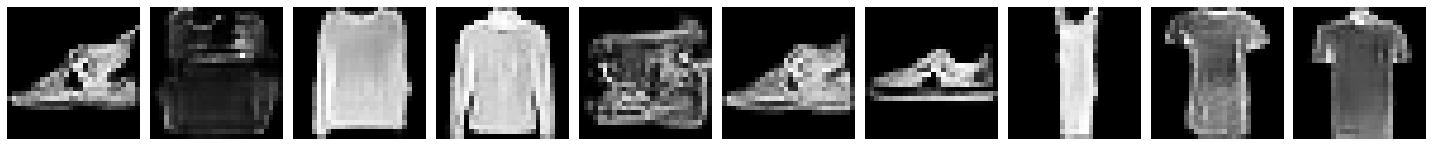

Epoch 65/100
547/547 - 25s - loss: 1.3971 - d_loss: 0.6645 - g_loss: 0.7326


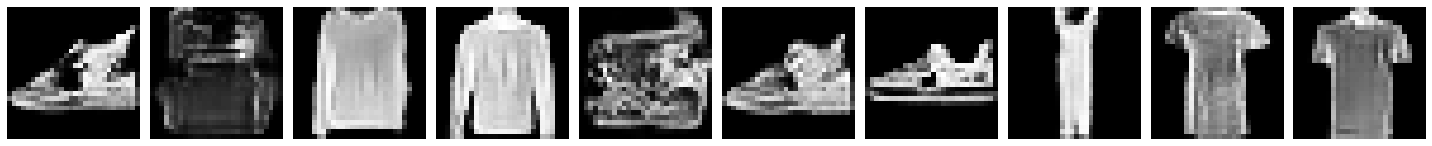

Epoch 66/100
547/547 - 25s - loss: 1.4037 - d_loss: 0.6643 - g_loss: 0.7394


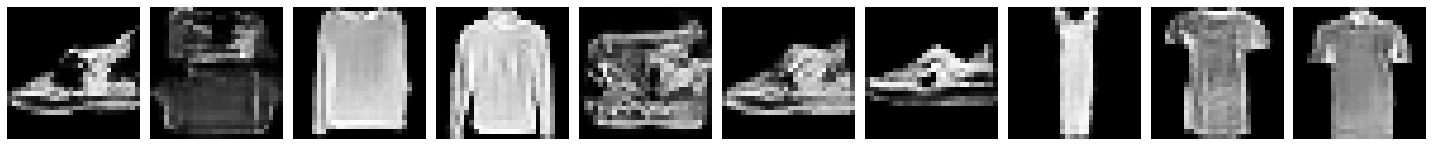

Epoch 67/100
547/547 - 25s - loss: 1.4389 - d_loss: 0.6627 - g_loss: 0.7762


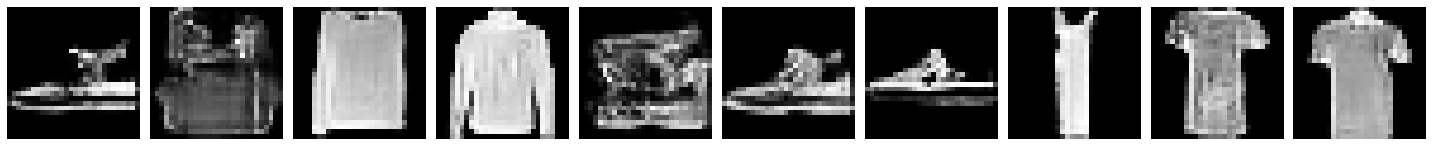

Epoch 68/100
547/547 - 25s - loss: 1.4228 - d_loss: 0.6630 - g_loss: 0.7598


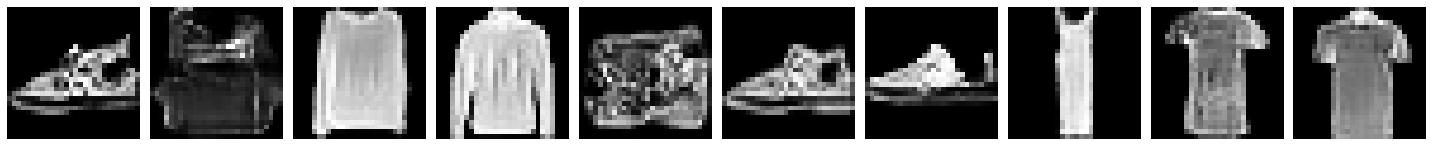

Epoch 69/100
547/547 - 25s - loss: 1.4064 - d_loss: 0.6623 - g_loss: 0.7441


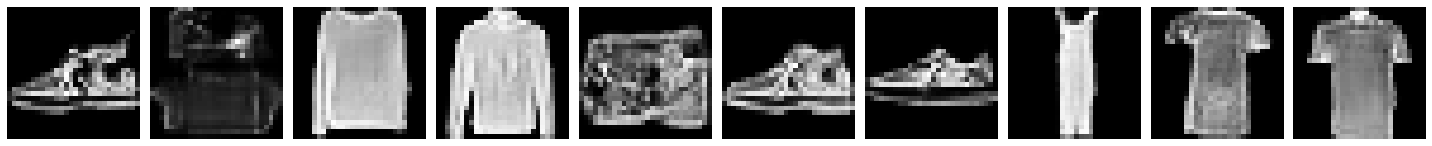

Epoch 70/100
547/547 - 25s - loss: 1.4434 - d_loss: 0.6620 - g_loss: 0.7814


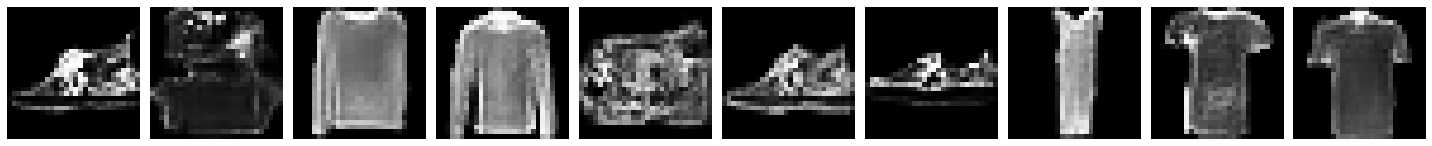

Epoch 71/100
547/547 - 25s - loss: 1.4210 - d_loss: 0.6602 - g_loss: 0.7609


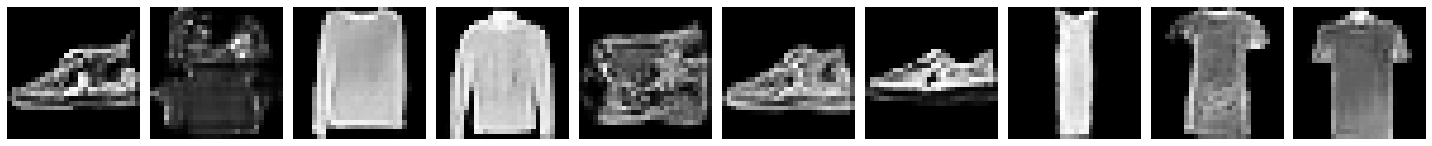

Epoch 72/100
547/547 - 25s - loss: 1.4131 - d_loss: 0.6621 - g_loss: 0.7510


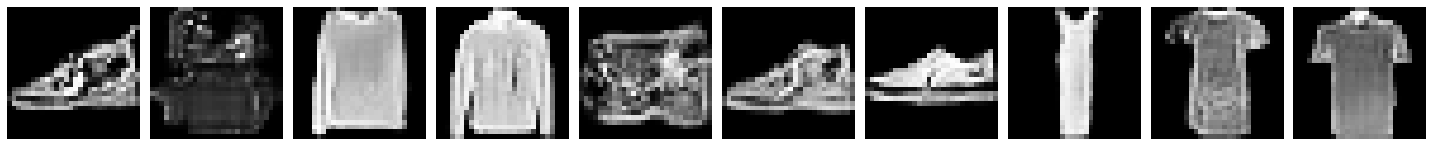

Epoch 73/100
547/547 - 25s - loss: 1.4078 - d_loss: 0.6622 - g_loss: 0.7457


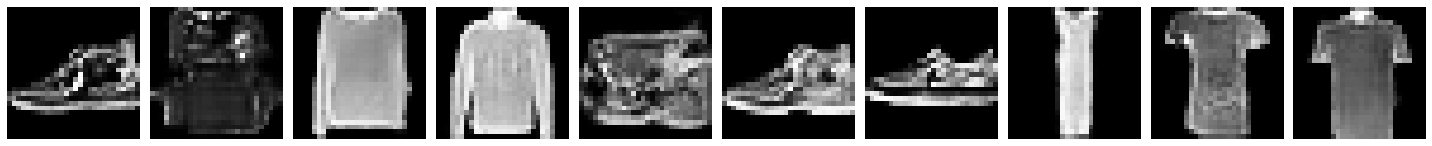

Epoch 74/100
547/547 - 25s - loss: 1.3974 - d_loss: 0.6626 - g_loss: 0.7349


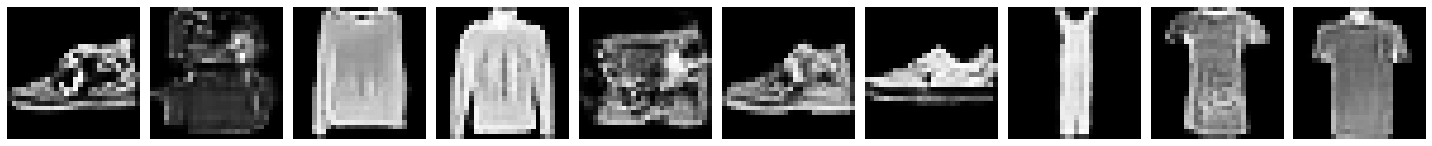

Epoch 75/100
547/547 - 25s - loss: 1.4097 - d_loss: 0.6619 - g_loss: 0.7479


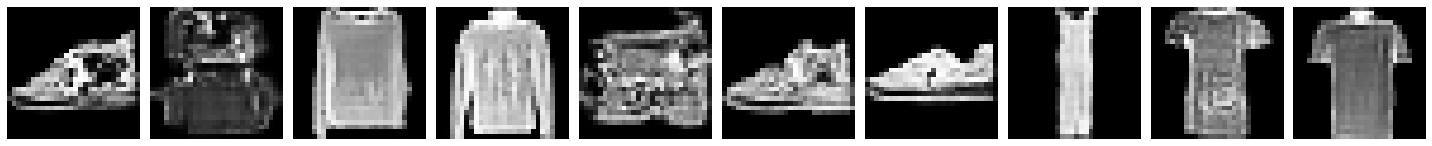

Epoch 76/100
547/547 - 25s - loss: 1.4410 - d_loss: 0.6614 - g_loss: 0.7796


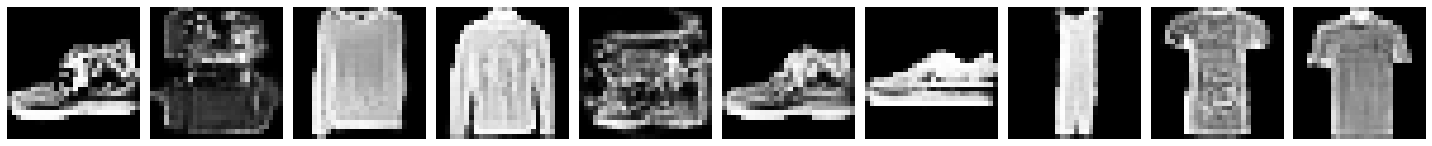

Epoch 77/100
547/547 - 25s - loss: 1.4219 - d_loss: 0.6561 - g_loss: 0.7658


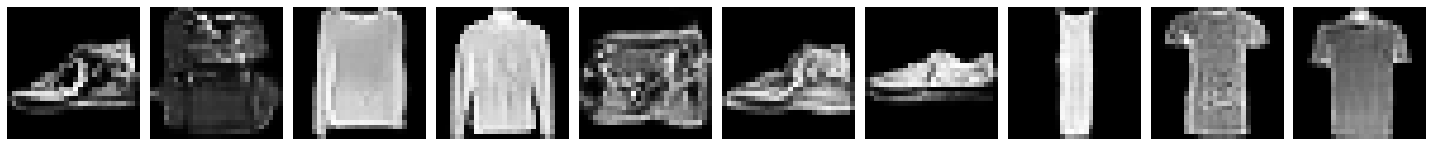

Epoch 78/100
547/547 - 25s - loss: 1.4022 - d_loss: 0.6643 - g_loss: 0.7378


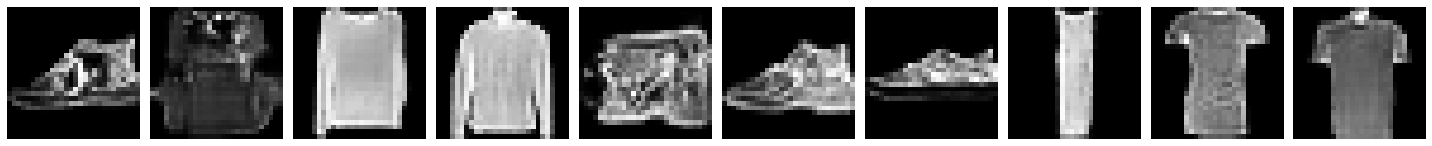

Epoch 79/100
547/547 - 25s - loss: 1.4220 - d_loss: 0.6608 - g_loss: 0.7612


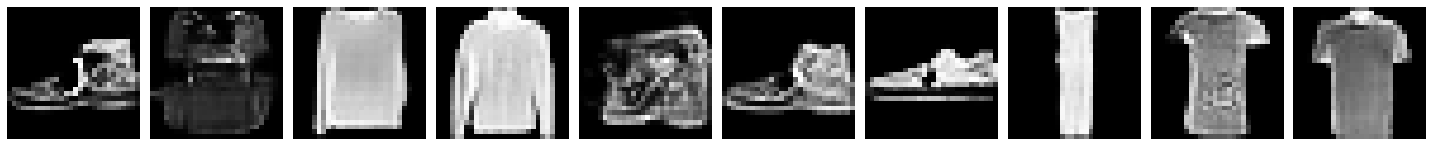

Epoch 80/100
547/547 - 25s - loss: 1.4086 - d_loss: 0.6634 - g_loss: 0.7452


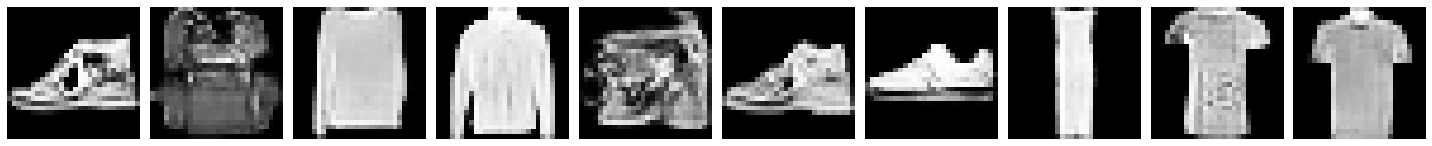

Epoch 81/100
547/547 - 25s - loss: 1.4144 - d_loss: 0.6633 - g_loss: 0.7512


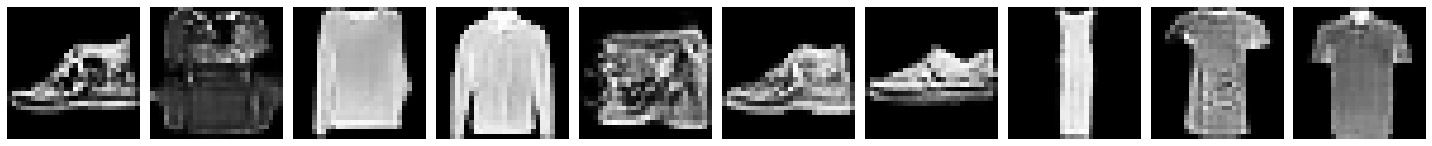

Epoch 82/100
547/547 - 25s - loss: 1.3870 - d_loss: 0.6637 - g_loss: 0.7233


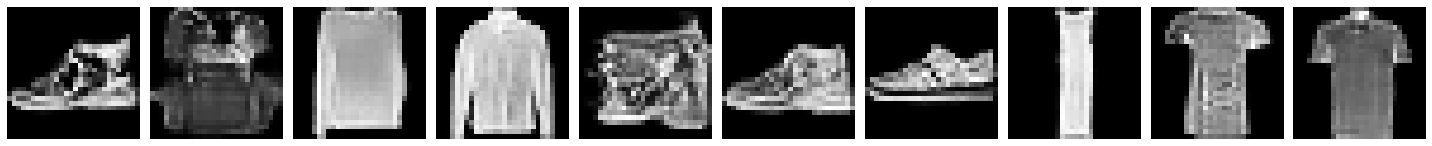

Epoch 83/100
547/547 - 25s - loss: 1.4189 - d_loss: 0.6648 - g_loss: 0.7540


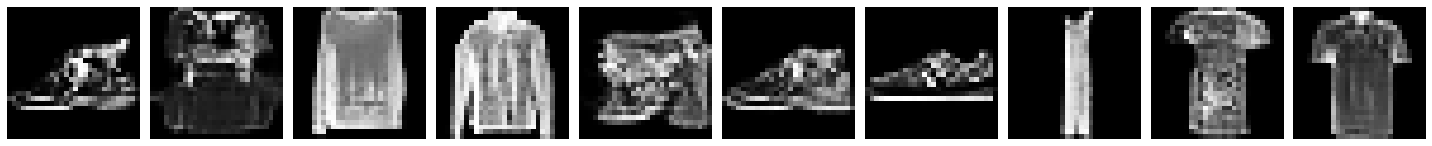

Epoch 84/100
547/547 - 25s - loss: 1.4279 - d_loss: 0.6572 - g_loss: 0.7707


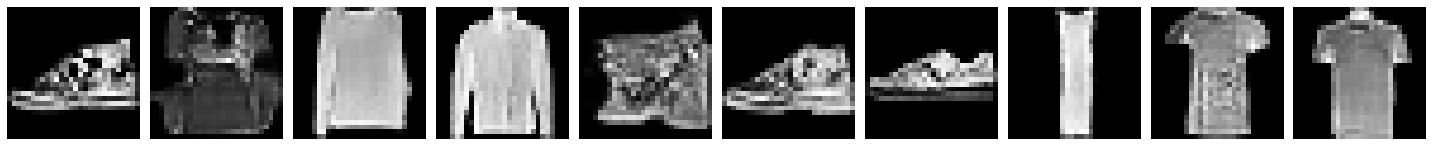

Epoch 85/100
547/547 - 25s - loss: 1.3947 - d_loss: 0.6651 - g_loss: 0.7296


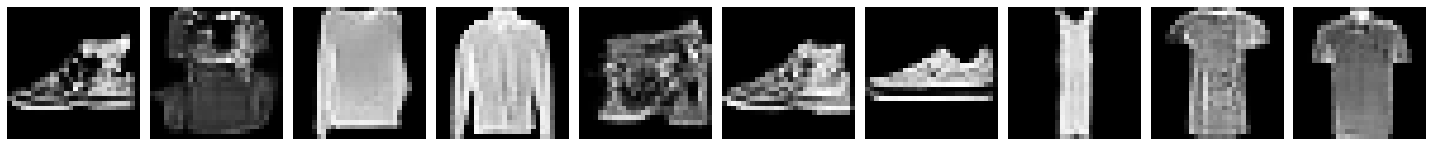

Epoch 86/100
547/547 - 25s - loss: 1.4054 - d_loss: 0.6649 - g_loss: 0.7405


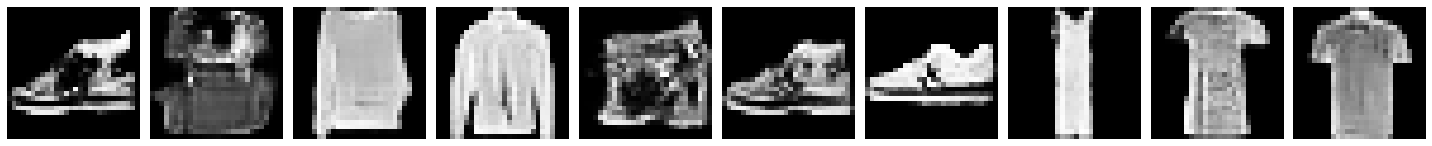

Epoch 87/100
547/547 - 25s - loss: 1.4936 - d_loss: 0.6552 - g_loss: 0.8384


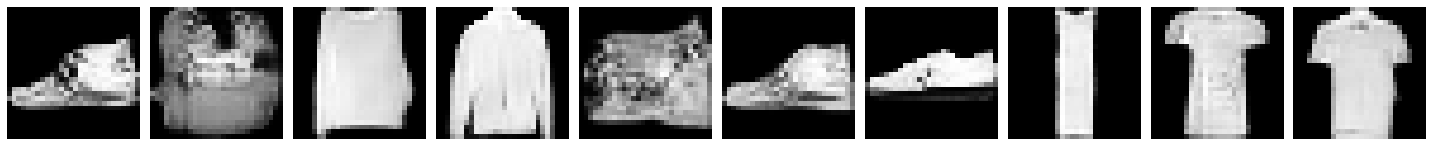

Epoch 88/100
547/547 - 25s - loss: 1.4192 - d_loss: 0.6612 - g_loss: 0.7581


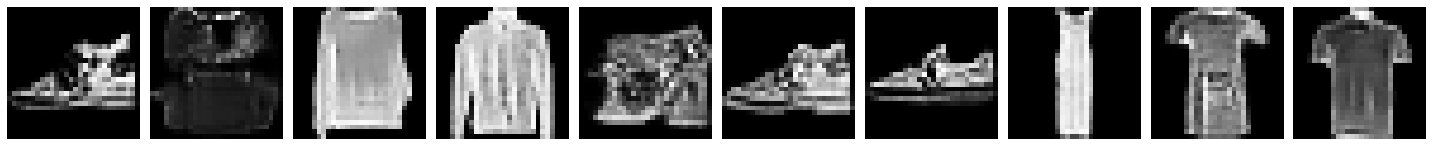

Epoch 89/100
547/547 - 25s - loss: 1.3870 - d_loss: 0.6641 - g_loss: 0.7229


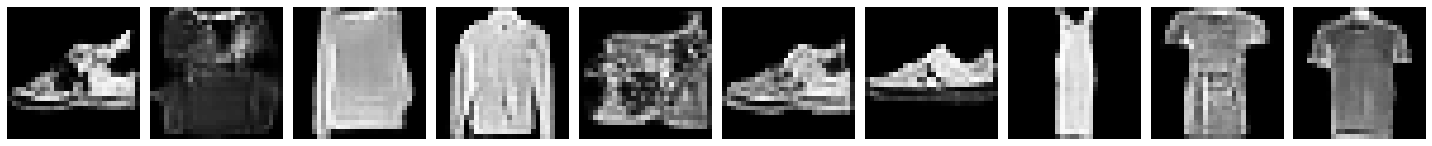

Epoch 90/100
547/547 - 25s - loss: 1.3910 - d_loss: 0.6644 - g_loss: 0.7266


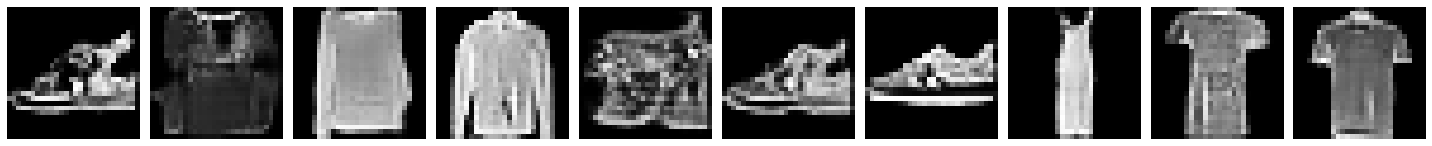

Epoch 91/100
547/547 - 25s - loss: 1.4303 - d_loss: 0.6607 - g_loss: 0.7696


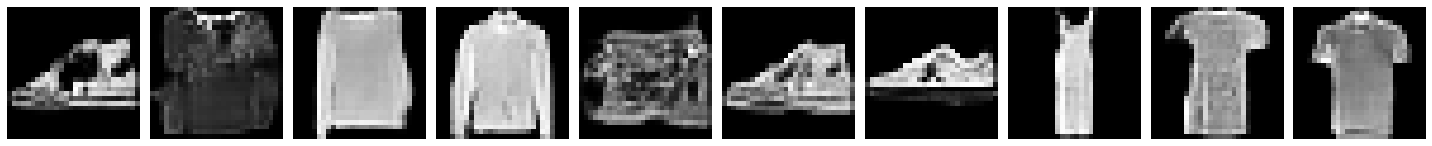

Epoch 92/100
547/547 - 25s - loss: 1.4015 - d_loss: 0.6643 - g_loss: 0.7372


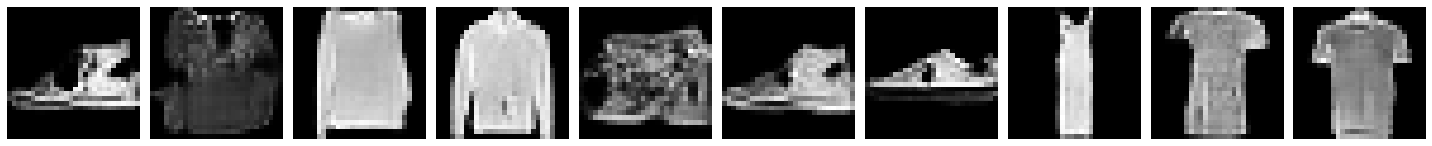

Epoch 93/100
547/547 - 25s - loss: 1.4300 - d_loss: 0.6613 - g_loss: 0.7687


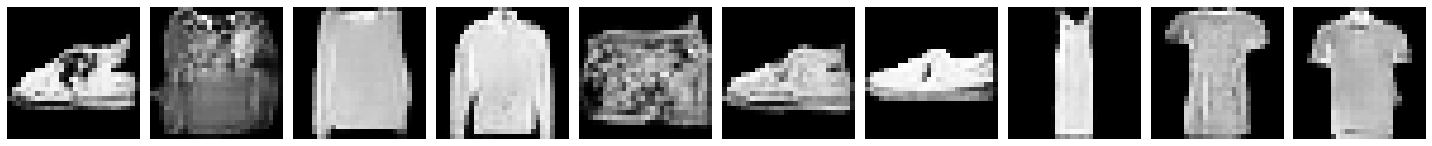

Epoch 94/100
547/547 - 25s - loss: 1.4497 - d_loss: 0.6590 - g_loss: 0.7907


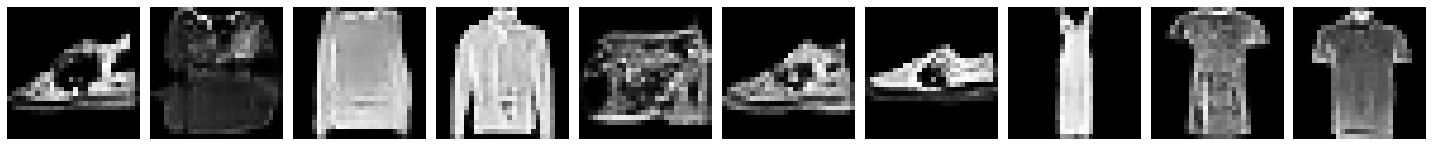

Epoch 95/100
547/547 - 25s - loss: 1.3850 - d_loss: 0.6652 - g_loss: 0.7199


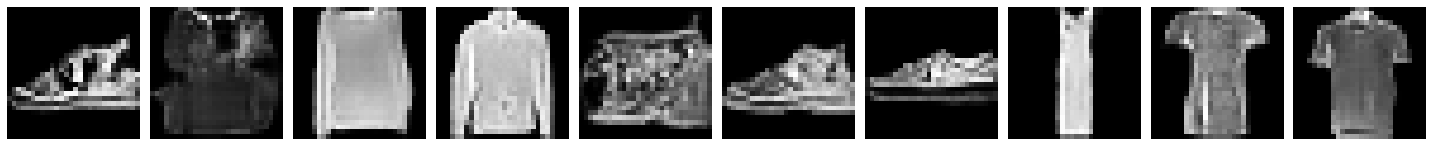

Epoch 96/100
547/547 - 25s - loss: 1.3900 - d_loss: 0.6636 - g_loss: 0.7264


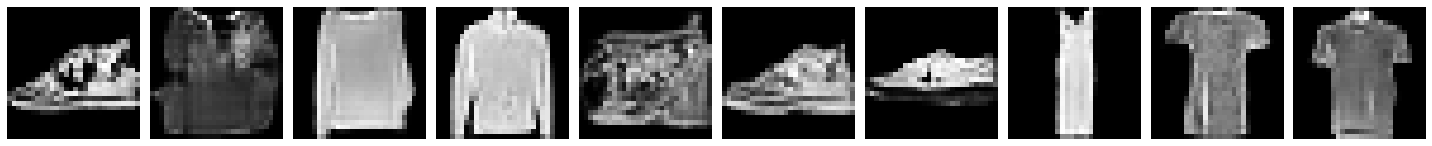

Epoch 97/100
547/547 - 25s - loss: 1.4128 - d_loss: 0.6640 - g_loss: 0.7488


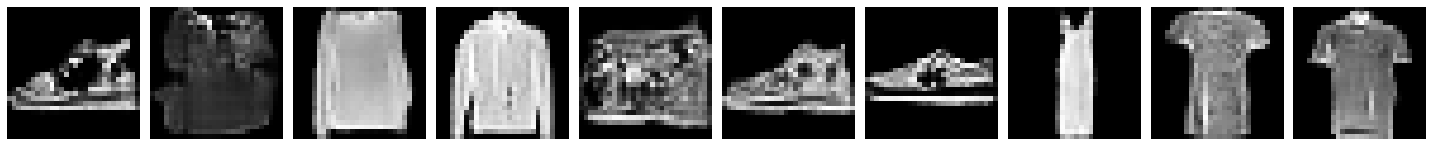

Epoch 98/100
547/547 - 25s - loss: 1.4077 - d_loss: 0.6624 - g_loss: 0.7453


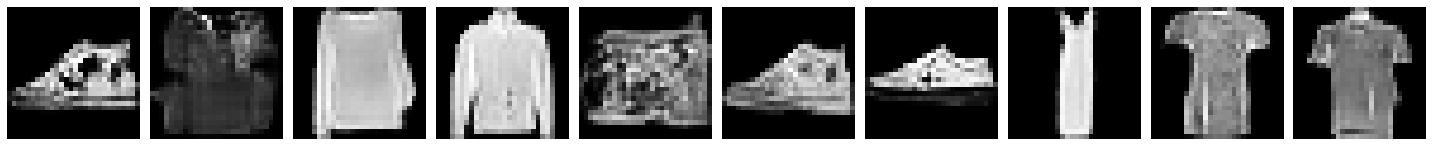

Epoch 99/100
547/547 - 25s - loss: 1.3942 - d_loss: 0.6635 - g_loss: 0.7307


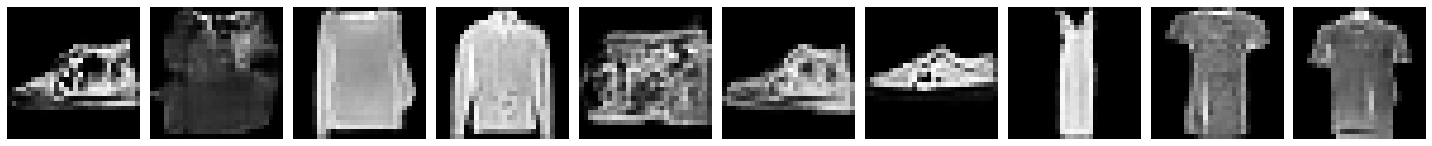

Epoch 100/100
547/547 - 25s - loss: 1.4013 - d_loss: 0.6635 - g_loss: 0.7378


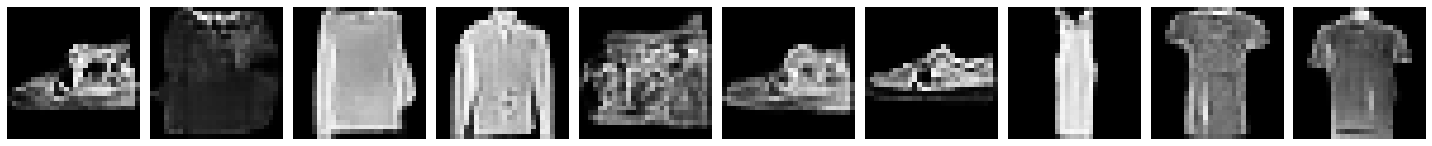

In [38]:
history = gan.fit(
    X, 
    epochs = epochs, 
    batch_size = batch_size,
    callbacks = [GANMonitor(name='vanilla', gray=True)],
    verbose = 2
).history

In [1]:
from IPython.display import FileLink
! zip -r gan.zip /kaggle/working/vanilla_gan_generator
FileLink(r'gan.zip')

updating: kaggle/working/vanilla_gan_generator/ (stored 0%)
updating: kaggle/working/vanilla_gan_generator/variables/ (stored 0%)
updating: kaggle/working/vanilla_gan_generator/variables/variables.index (deflated 62%)
updating: kaggle/working/vanilla_gan_generator/variables/variables.data-00000-of-00001 (deflated 8%)
updating: kaggle/working/vanilla_gan_generator/keras_metadata.pb (deflated 93%)
updating: kaggle/working/vanilla_gan_generator/saved_model.pb (deflated 90%)


/kaggle/working/gan.zip

In [21]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='GAN loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)
plt.show()

NameError: name 'history' is not defined

<Figure size 1440x360 with 0 Axes>

In [ ]:
gan.generator.save('vanilla_gan_generator')

In [ ]:
vanilla_gan_generator = tfk.models.load_model('vanilla_gan_generator')

In [ ]:
sample(vanilla_gan_generator, 10, latent_dim, fixed=False, gray=True)
sample(vanilla_gan_generator, 10, latent_dim, fixed=False, gray=True)
# we did not give the model info about labels, it cannot discriminate between images 

In [ ]:
imgs = 2500
X_hat = generate_dataset(vanilla_gan_generator, imgs, latent_dim)*127.5 + 127+5
X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))
X_hat = np.mean(X_hat, axis=0)

X_temp = X[:imgs]*127.5 + 127+5 #going back to original img (see before)
X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
X_temp = np.mean(X_temp, axis=0)

print(X_hat.shape, X_temp.shape)

In [ ]:
plt.figure(figsize=(10,4))
sns.kdeplot(x=X_hat, label='Sampled data', linewidth=3)
sns.kdeplot(x=X_temp, label='Real data', linewidth=3)
plt.legend()
plt.show()
# this models tries to make sampled distribution as simple as possible to the real data (input) distribution 

### Deep Convolutional Conditional GAN

In [26]:
image_size = input_shape[0]
num_classes = len(np.unique(y))
num_channels = input_shape[-1]

In [27]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes #porcata but it works
print(generator_in_channels, discriminator_in_channels)

138 11


We are computing a conditional probability, so this is named conditional GAN 

In [28]:
conditional_generator_input = (generator_in_channels)
conditional_discriminator_input = (image_size, image_size, discriminator_in_channels)
conditional_discriminator_input, conditional_generator_input

((28, 28, 11), 138)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 11)]      0         
_________________________________________________________________
padding (ZeroPadding2D)      (None, 32, 32, 11)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        6400      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
activation1 (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 8, 128)         73856     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 8, 8, 128)       

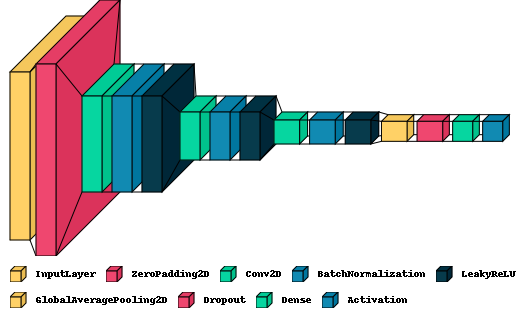

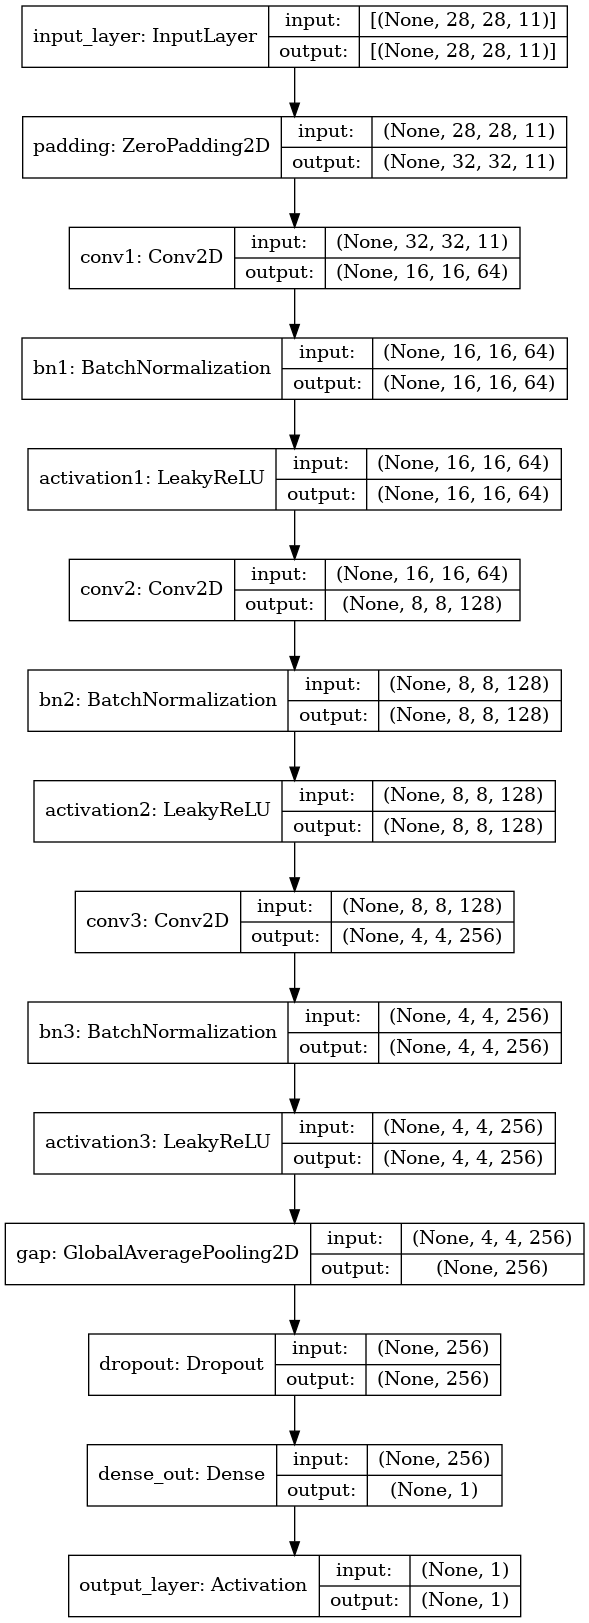

In [29]:
discriminator = get_dc_discriminator(conditional_discriminator_input)
discriminator.summary()
display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='conditional_discriminator.png')

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 138)]             0         
_________________________________________________________________
dense0 (Dense)               (None, 1024)              141312    
_________________________________________________________________
bn0 (BatchNormalization)     (None, 1024)              4096      
_________________________________________________________________
activation0 (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
upsampling1 (UpSampling2D)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 8, 8, 64)          36

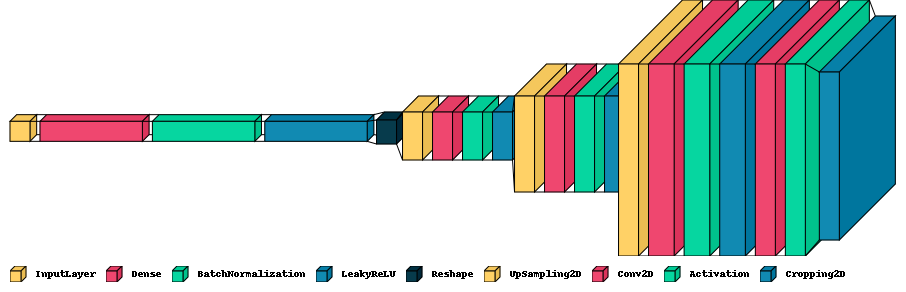

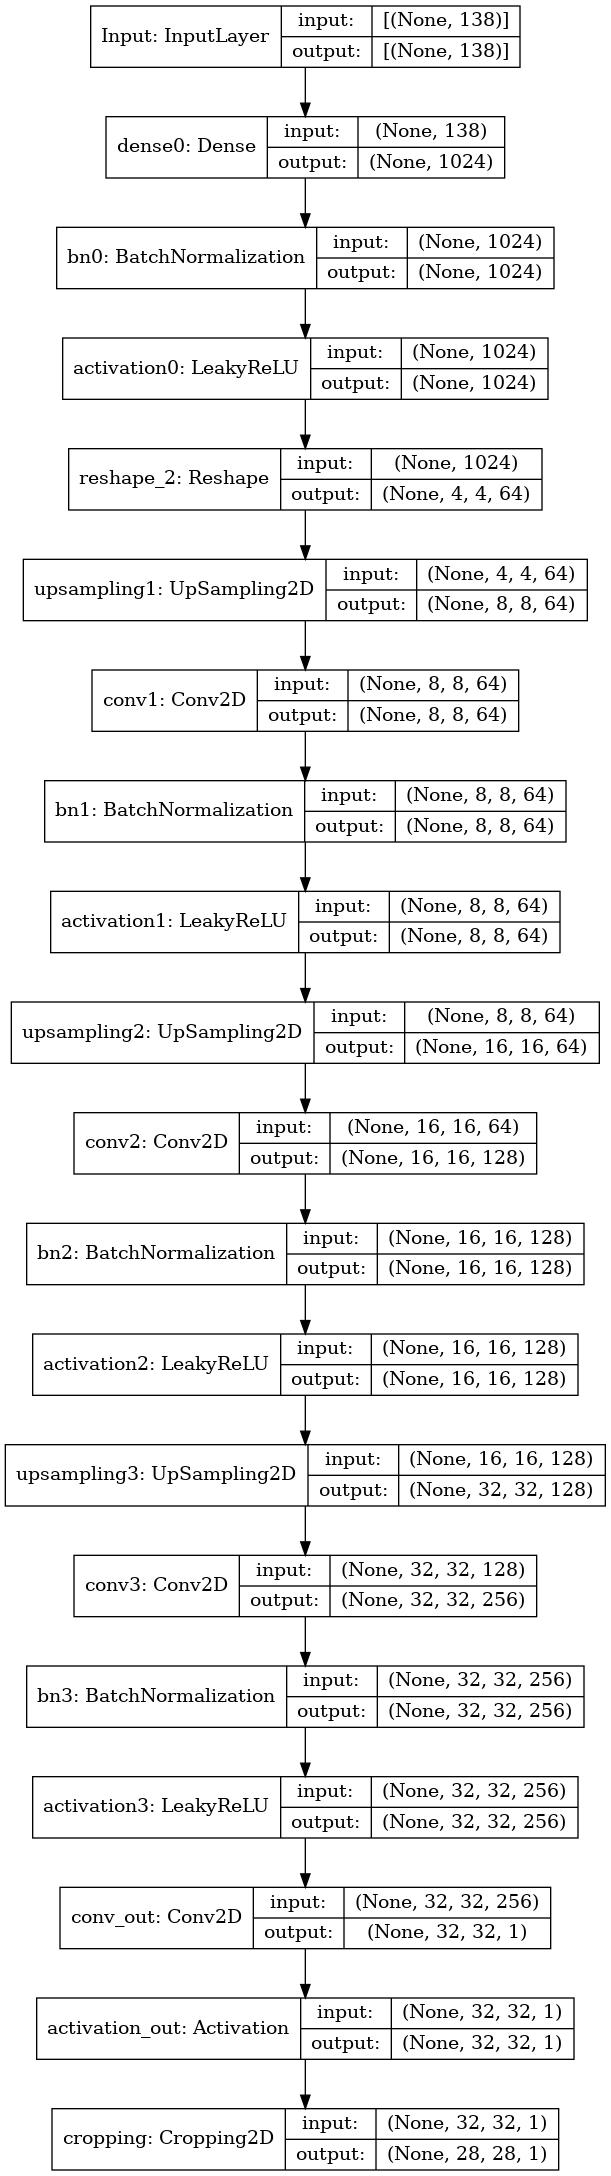

In [30]:
generator = get_dc_generator(conditional_generator_input)
generator.summary()
display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='conditional_generator.png')

In [31]:
class ConditionalGAN(tfk.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]

    @tf.function
    def train_step(self, data): #we are receiving img + labels in one hot encoding 
        real_images, one_hot_labels = data
        batch_size = tf.shape(real_images)[0]
        
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size * image_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))
        
        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        z = tf.concat([z, one_hot_labels], -1) #in each batch we want to have same classes for real img and for generated ones 

        # Generate fake images from z
        generated_images = self.generator(z)

        
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        # Combine generated images and real ones
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        # Create labels so that fake images correspond to class 0 and real images to class 1
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(labels, predictions))
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        loss = d_loss

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        z = tf.concat([z, one_hot_labels], axis=1)

        # Create misleading labels for fake images so that they correspond to class 1
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            fake_images = self.generator(z)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            misleading_predictions = self.discriminator(fake_image_and_labels)
            g_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(misleading_labels, misleading_predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        loss += g_loss

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "loss": self.loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [32]:
# little bit different to take into account labels, check it out on rec

class ConditionalGANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray

    def on_epoch_end(self, epoch, logs=None):
        tf.random.set_seed(seed)
        os.makedirs(self.name+'temp', exist_ok=True)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        labels = tf.cast(tf.math.floormod(tf.range(0,self.num_img), num_classes), 'float32')
        labels = tfk.utils.to_categorical(labels, num_classes)
        random_latent_vectors = tf.concat([random_latent_vectors,labels],-1)
        generated_images = self.model.generator(random_latent_vectors).numpy()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20,2*self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i%self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')
        fig.savefig(self.name+'temp/'+'{:0>5}'.format(epoch)+'.png') 
        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
        fp_in = self.name+"temp/*.png"
        fp_out = self.name+"_generated_images.gif"
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, optimize=False)    
        shutil.rmtree(self.name+"temp")

In [33]:
all_labels = tfk.utils.to_categorical(y, num_classes)
dataset = tf.data.Dataset.from_tensor_slices((X, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [34]:
cgan = ConditionalGAN(
    discriminator = get_dc_discriminator(conditional_discriminator_input), 
    generator = get_dc_generator(conditional_generator_input), 
    latent_dim = latent_dim
)
cgan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
)

In [35]:
def conditional_sample(model, num_img, latent_dim, fixed=True, gray=False, label=None): #fix to a particular class 
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    z = tf.concat([z,labels],-1)
    generated_images = model(z).numpy()

    fig, axes = plt.subplots(1, num_img, figsize=(20,2*num_img))
    for i in range(num_img):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i%num_img]
        if gray:
            ax.imshow(np.squeeze(img), cmap='gray')
        else:
            ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def generate_conditional_dataset(model, num_img, latent_dim, fixed=True, label=None):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    z = tf.concat([z,labels],-1)
    generated_images = model(z).numpy()
    return generated_images, labels

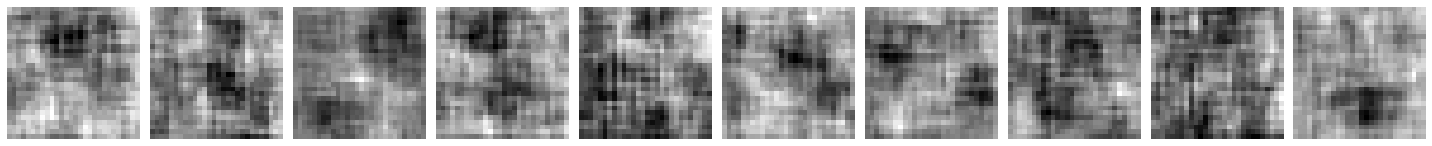

In [36]:
conditional_sample(cgan.generator, 10, latent_dim, gray=True)

Epoch 1/100
547/547 - 27s - loss: 1.7425 - d_loss: 0.5874 - g_loss: 1.1551


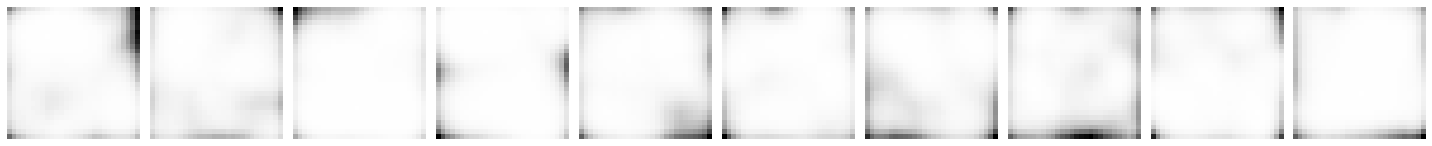

Epoch 2/100
547/547 - 26s - loss: 2.6719 - d_loss: 0.2307 - g_loss: 2.4412


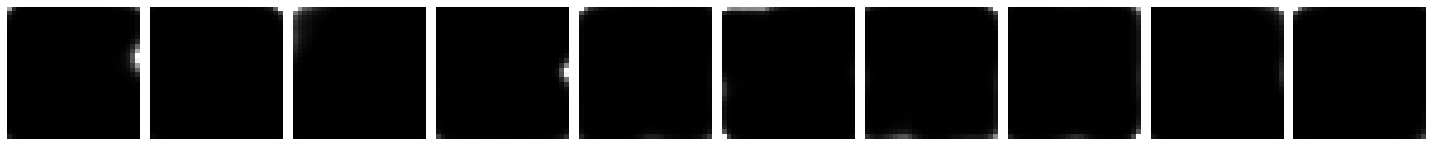

Epoch 3/100
547/547 - 26s - loss: 4.4970 - d_loss: 0.0200 - g_loss: 4.4770


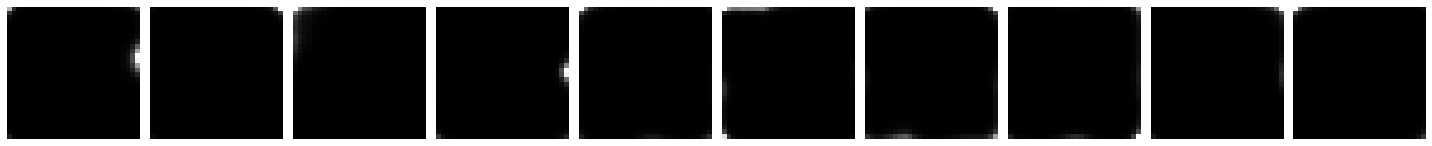

Epoch 4/100
547/547 - 26s - loss: 5.3544 - d_loss: 0.0083 - g_loss: 5.3461


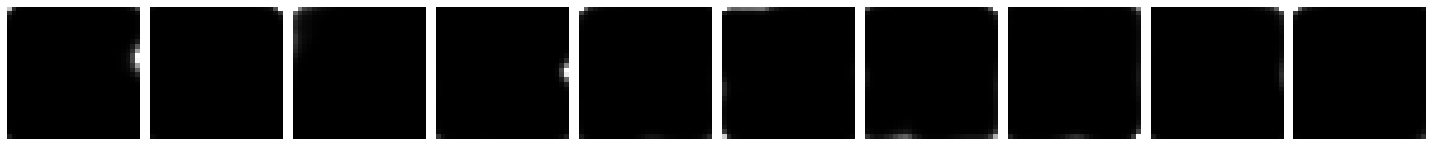

Epoch 5/100
547/547 - 26s - loss: 5.9431 - d_loss: 0.0045 - g_loss: 5.9386


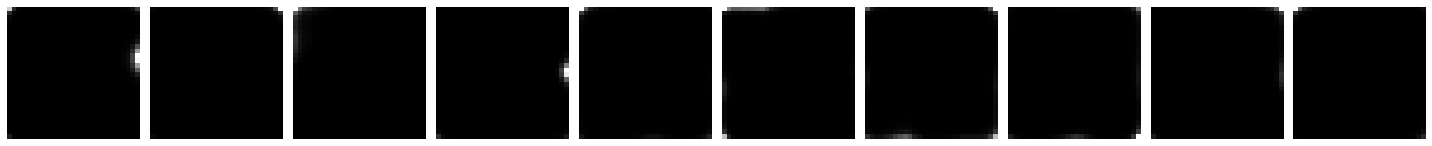

Epoch 6/100
547/547 - 26s - loss: 6.4214 - d_loss: 0.0027 - g_loss: 6.4187


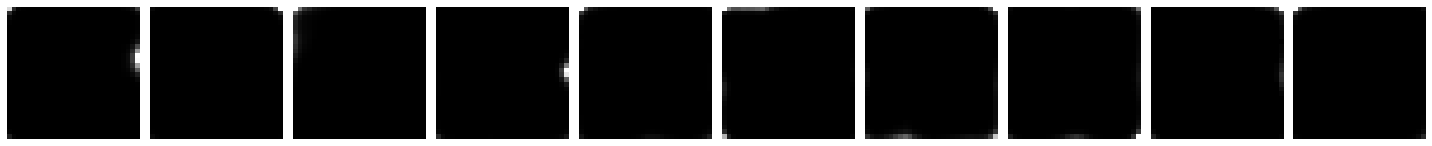

Epoch 7/100
547/547 - 26s - loss: 6.8890 - d_loss: 0.0019 - g_loss: 6.8871


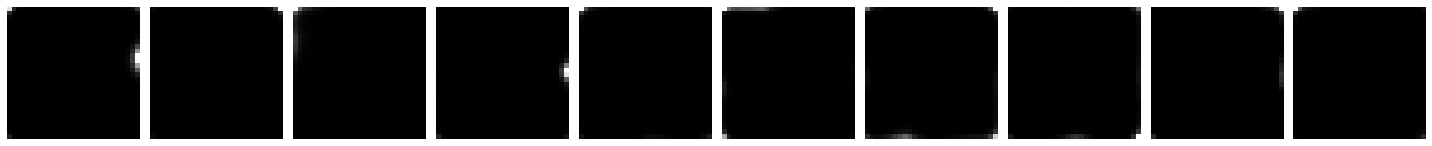

Epoch 8/100
547/547 - 26s - loss: 7.3003 - d_loss: 0.0013 - g_loss: 7.2990


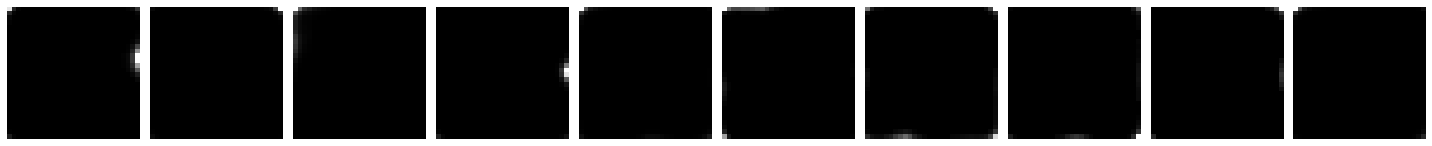

Epoch 9/100
547/547 - 26s - loss: 7.6435 - d_loss: 9.3928e-04 - g_loss: 7.6426


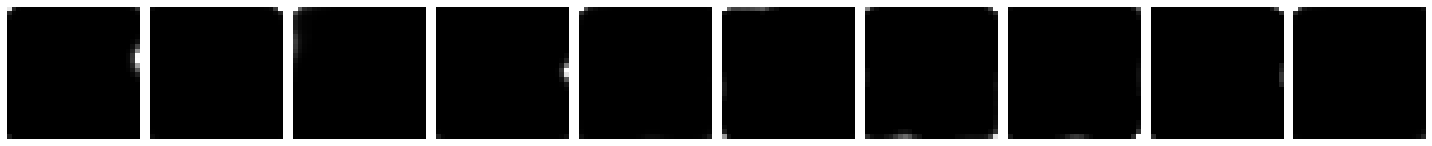

Epoch 10/100
547/547 - 26s - loss: 8.0684 - d_loss: 7.2788e-04 - g_loss: 8.0677


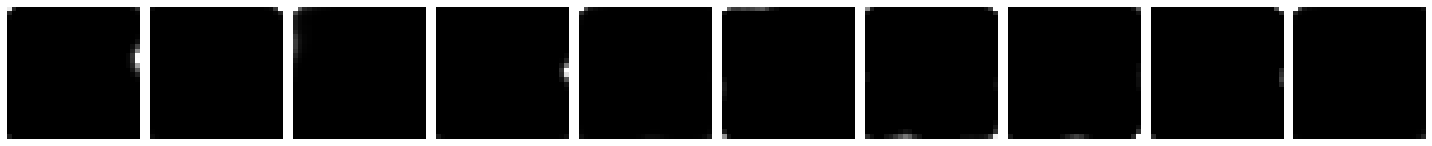

Epoch 11/100
547/547 - 26s - loss: 8.4452 - d_loss: 5.3001e-04 - g_loss: 8.4447


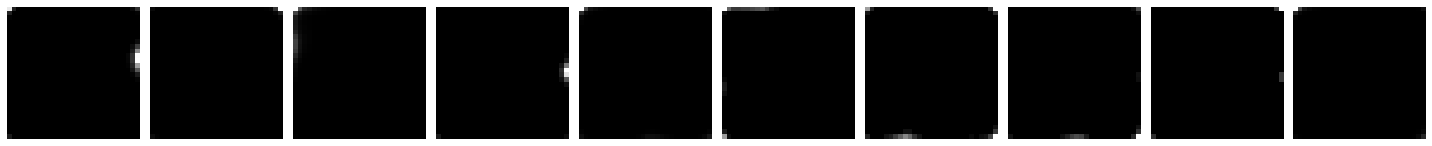

Epoch 12/100
547/547 - 26s - loss: 8.7640 - d_loss: 4.5735e-04 - g_loss: 8.7636


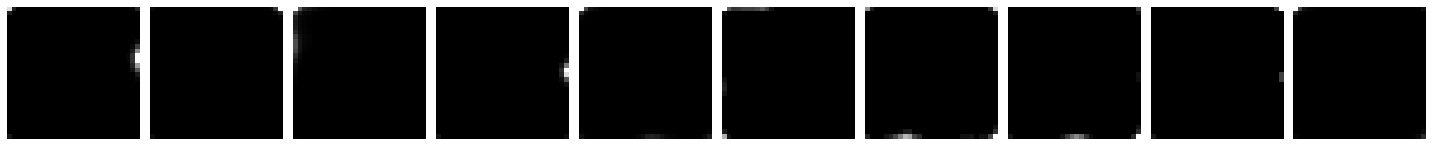

Epoch 13/100
547/547 - 26s - loss: 8.9096 - d_loss: 0.5183 - g_loss: 8.3912


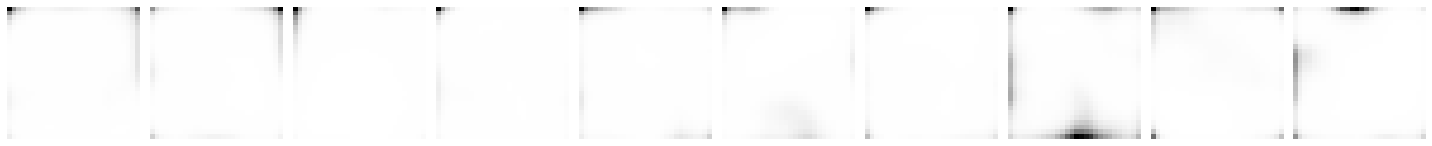

Epoch 14/100
547/547 - 26s - loss: 5.7932 - d_loss: 0.1525 - g_loss: 5.6406


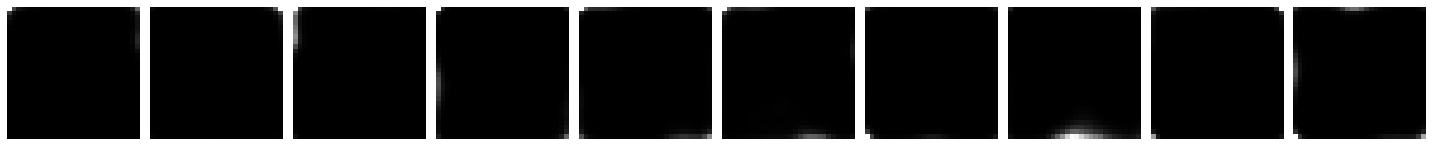

Epoch 15/100
547/547 - 26s - loss: 3.8827 - d_loss: 0.0369 - g_loss: 3.8458


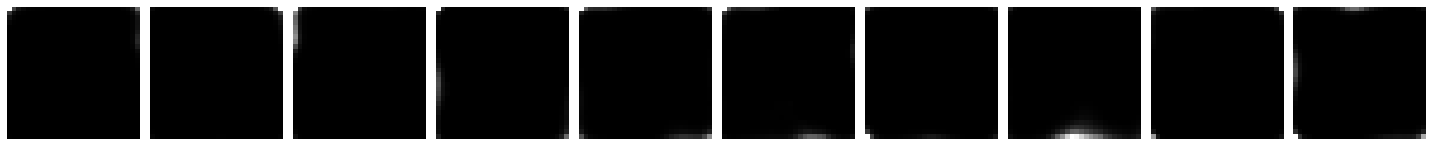

Epoch 16/100
547/547 - 26s - loss: 4.7262 - d_loss: 0.0161 - g_loss: 4.7101


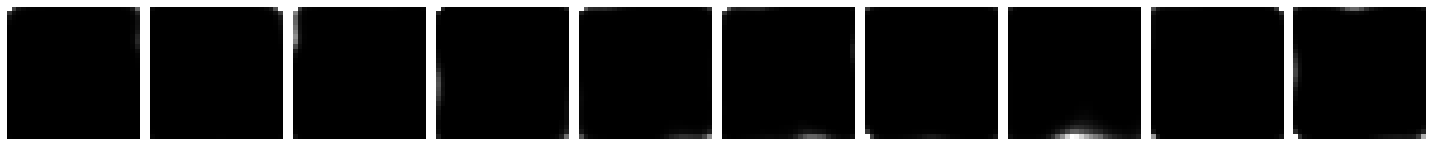

Epoch 17/100
547/547 - 26s - loss: 5.4211 - d_loss: 0.0084 - g_loss: 5.4127


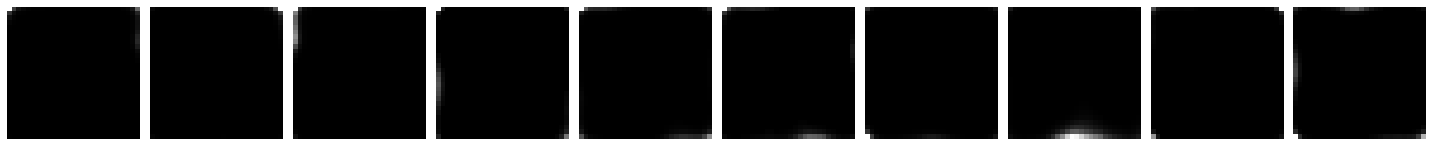

Epoch 18/100
547/547 - 26s - loss: 5.9505 - d_loss: 0.0052 - g_loss: 5.9452


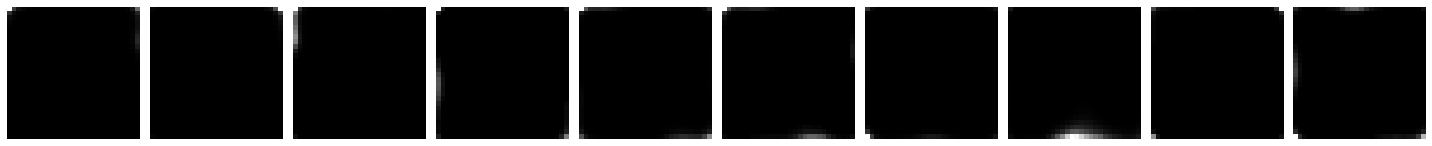

Epoch 19/100
547/547 - 26s - loss: 6.4015 - d_loss: 0.0035 - g_loss: 6.3980


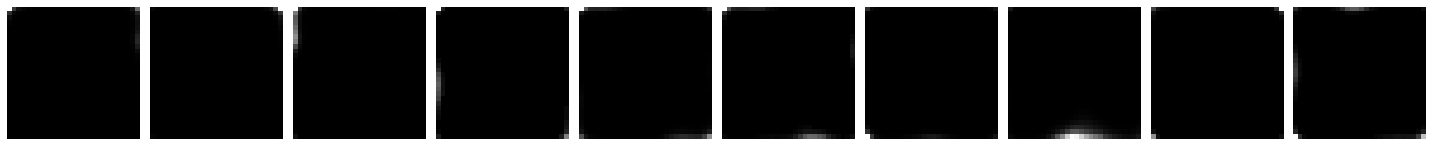

Epoch 20/100
547/547 - 26s - loss: 6.8007 - d_loss: 0.0025 - g_loss: 6.7982


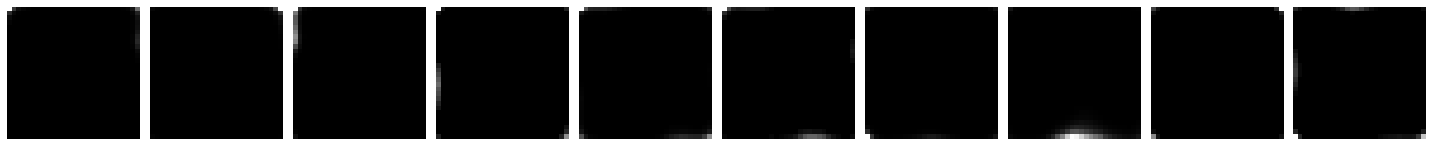

Epoch 21/100
547/547 - 26s - loss: 7.1285 - d_loss: 0.0018 - g_loss: 7.1267


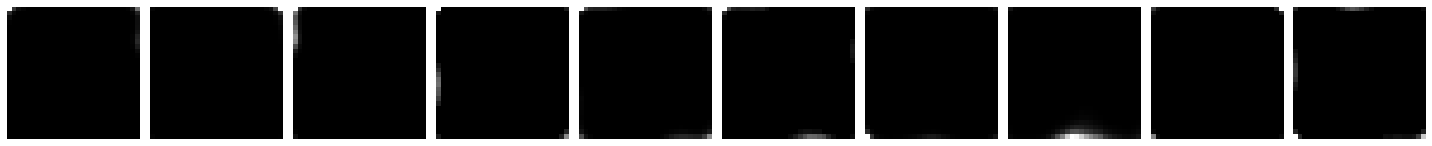

Epoch 22/100
547/547 - 26s - loss: 7.4256 - d_loss: 0.0013 - g_loss: 7.4243


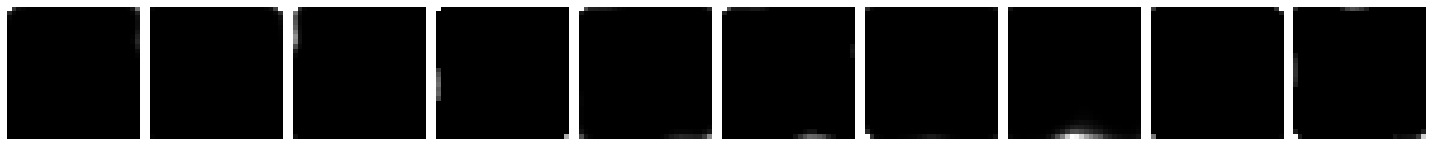

Epoch 23/100
547/547 - 26s - loss: 7.7254 - d_loss: 9.7796e-04 - g_loss: 7.7244


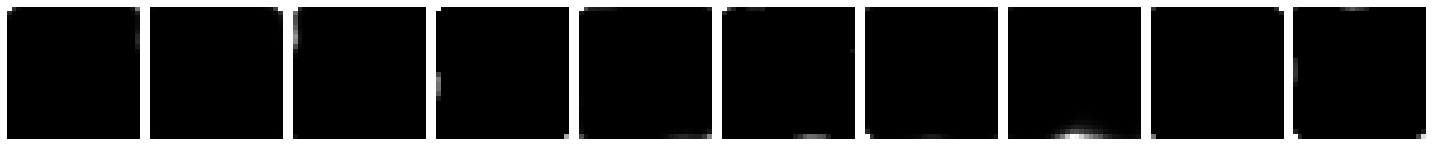

Epoch 24/100
547/547 - 26s - loss: 8.0153 - d_loss: 7.7869e-04 - g_loss: 8.0145


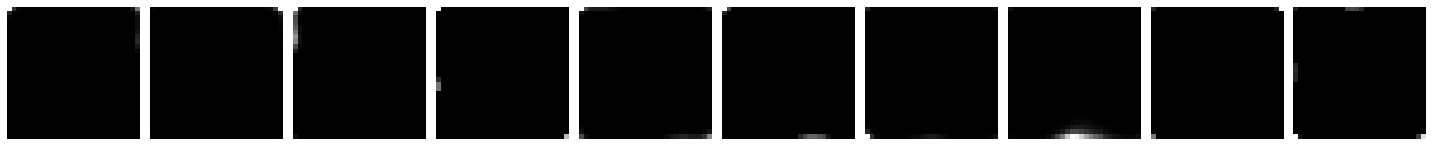

Epoch 25/100
547/547 - 26s - loss: 8.2982 - d_loss: 6.3550e-04 - g_loss: 8.2975


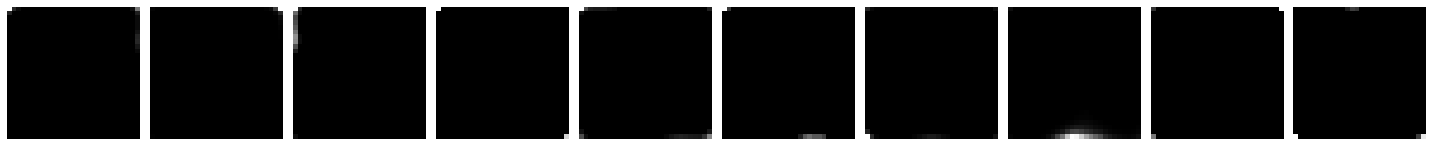

Epoch 26/100
547/547 - 26s - loss: 8.5526 - d_loss: 4.9813e-04 - g_loss: 8.5521


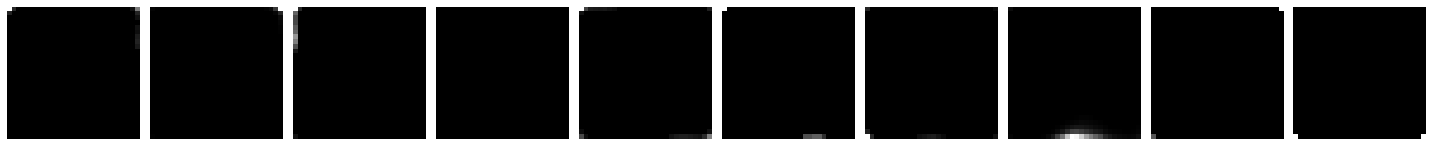

Epoch 27/100
547/547 - 26s - loss: 8.8156 - d_loss: 4.1945e-04 - g_loss: 8.8152


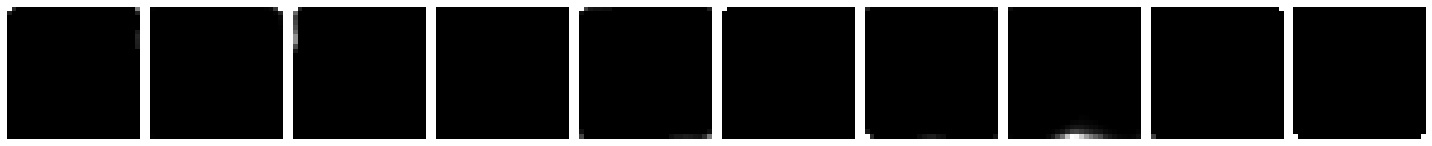

Epoch 28/100
547/547 - 26s - loss: 9.1503 - d_loss: 3.5374e-04 - g_loss: 9.1499


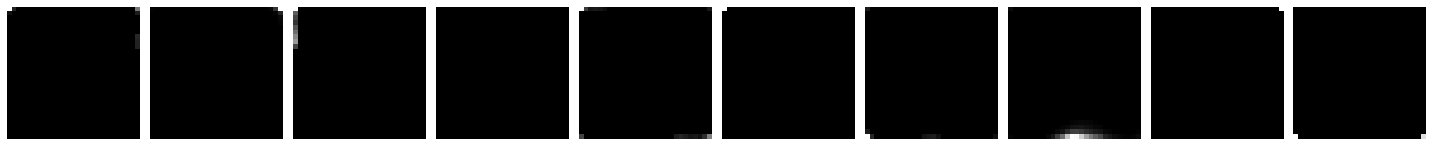

Epoch 29/100
547/547 - 26s - loss: 9.4061 - d_loss: 2.9897e-04 - g_loss: 9.4058


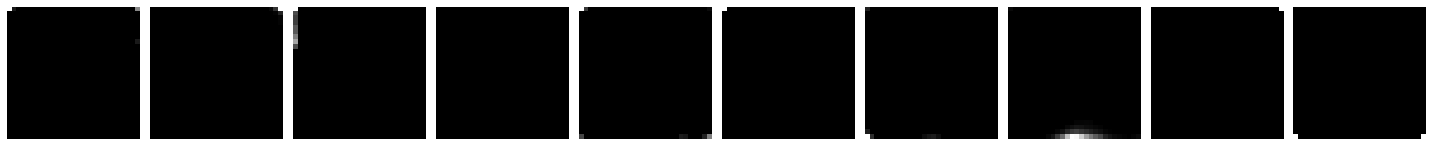

Epoch 30/100
547/547 - 26s - loss: 9.6749 - d_loss: 2.6596e-04 - g_loss: 9.6746


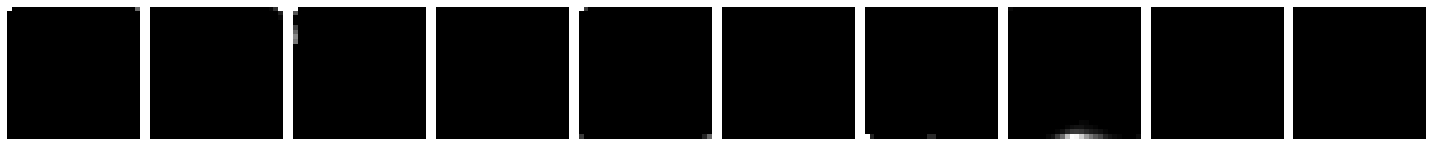

Epoch 31/100
547/547 - 26s - loss: 9.9804 - d_loss: 2.4560e-04 - g_loss: 9.9801


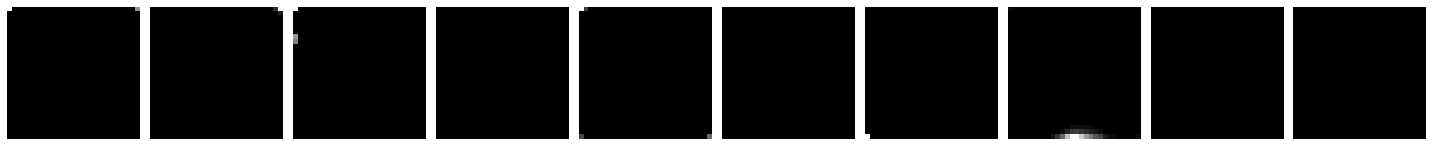

Epoch 32/100
547/547 - 26s - loss: 10.2007 - d_loss: 1.8811e-04 - g_loss: 10.2005


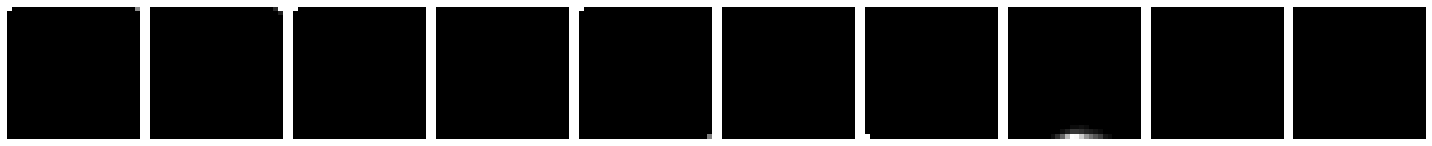

Epoch 33/100
547/547 - 26s - loss: 10.4217 - d_loss: 1.6191e-04 - g_loss: 10.4216


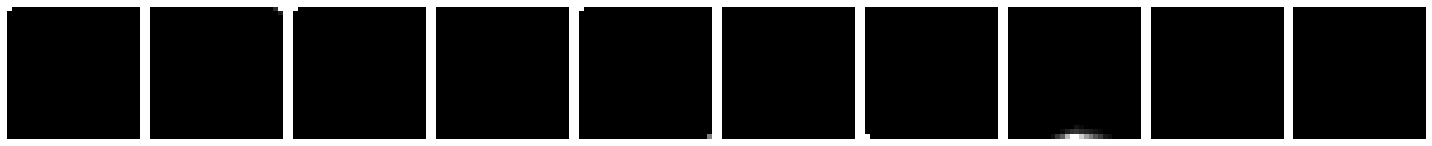

Epoch 34/100
547/547 - 26s - loss: 10.7504 - d_loss: 1.3987e-04 - g_loss: 10.7503


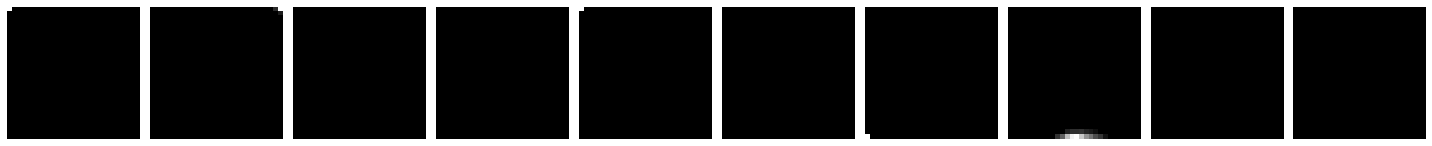

Epoch 35/100
547/547 - 26s - loss: 11.0350 - d_loss: 1.1661e-04 - g_loss: 11.0349


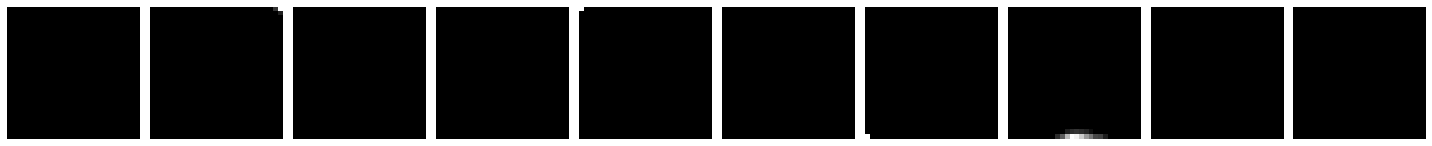

Epoch 36/100
547/547 - 26s - loss: 11.2306 - d_loss: 1.3574e-04 - g_loss: 11.2305


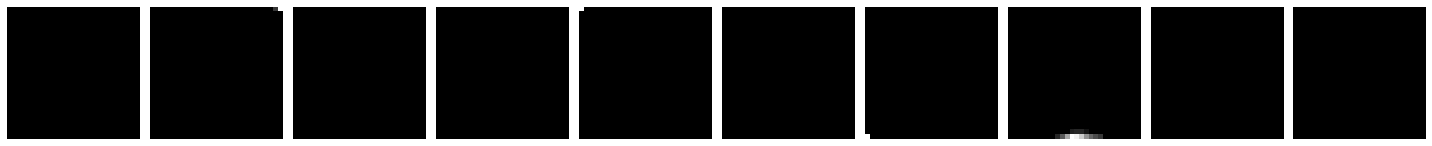

Epoch 37/100
547/547 - 26s - loss: 11.5179 - d_loss: 1.5201e-04 - g_loss: 11.5178


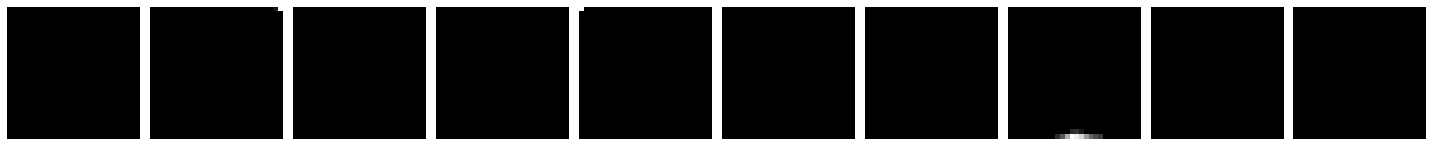

Epoch 38/100
547/547 - 26s - loss: 11.5579 - d_loss: 9.5870e-05 - g_loss: 11.5578


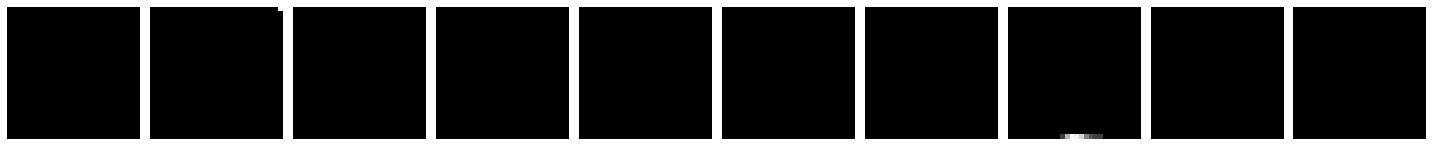

Epoch 39/100
547/547 - 26s - loss: 11.7524 - d_loss: 7.4479e-05 - g_loss: 11.7523


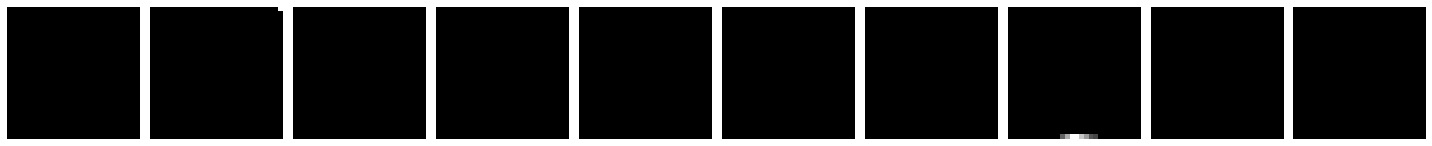

Epoch 40/100
547/547 - 26s - loss: 12.1132 - d_loss: 7.5866e-05 - g_loss: 12.1131


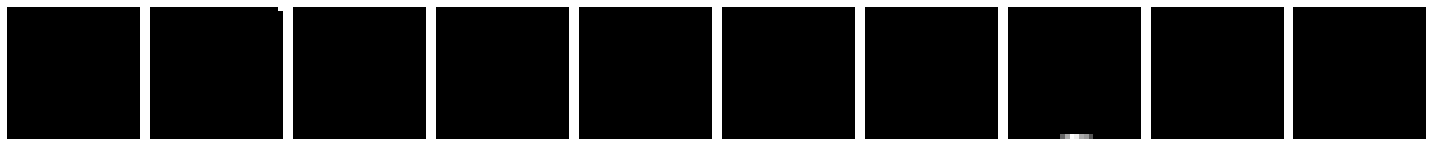

Epoch 41/100
547/547 - 26s - loss: 12.3556 - d_loss: 5.4211e-05 - g_loss: 12.3556


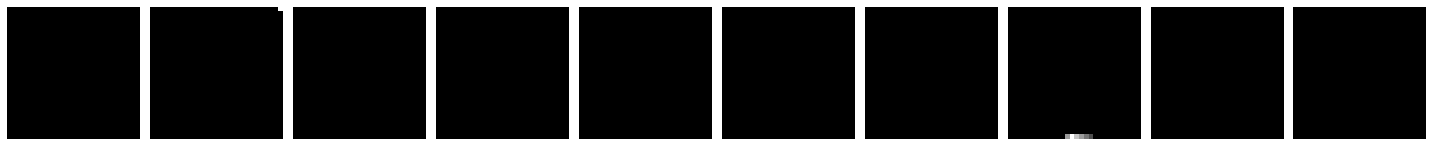

Epoch 42/100
547/547 - 26s - loss: 12.5772 - d_loss: 3.9959e-05 - g_loss: 12.5772


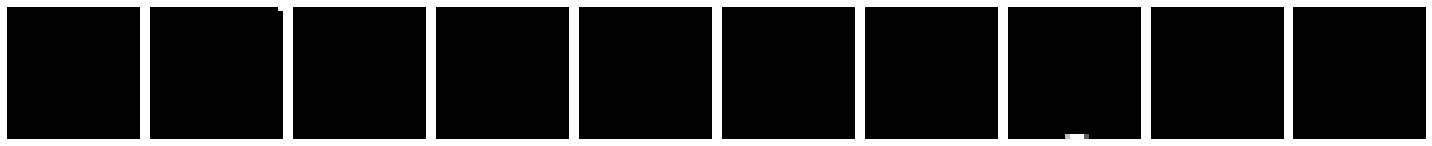

Epoch 43/100
547/547 - 26s - loss: 12.7529 - d_loss: 5.0030e-05 - g_loss: 12.7529


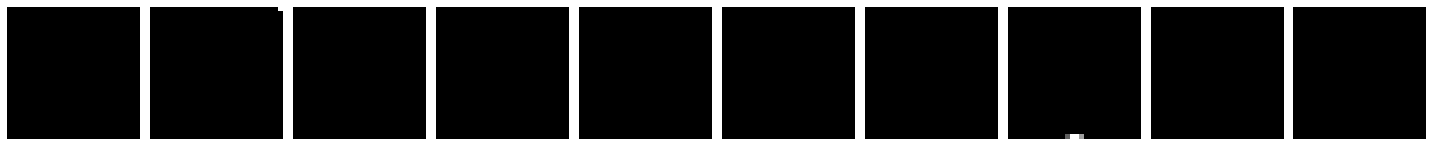

Epoch 44/100
547/547 - 26s - loss: 12.3466 - d_loss: 1.1699e-04 - g_loss: 12.3465


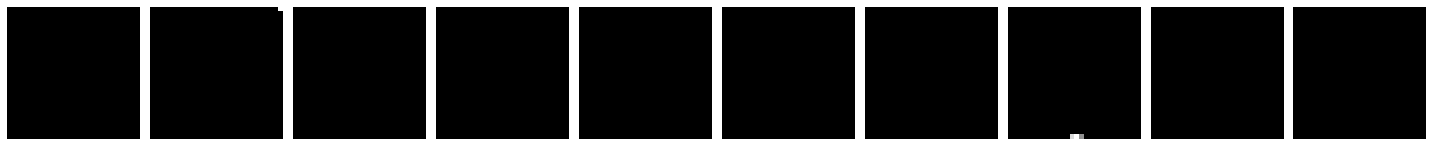

Epoch 45/100
547/547 - 26s - loss: 12.6357 - d_loss: 5.6691e-05 - g_loss: 12.6356


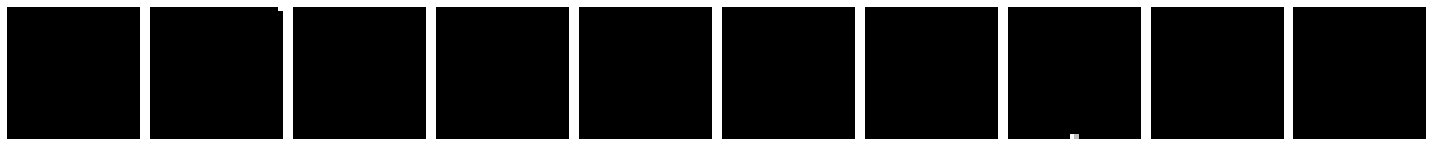

Epoch 46/100
547/547 - 26s - loss: 12.6377 - d_loss: 3.9008e-05 - g_loss: 12.6376


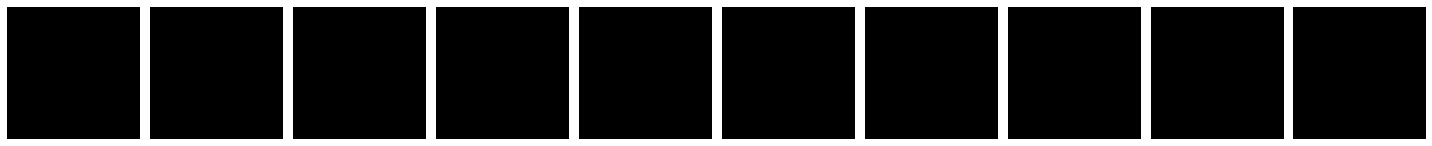

Epoch 47/100
547/547 - 26s - loss: 12.7686 - d_loss: 3.3714e-05 - g_loss: 12.7686


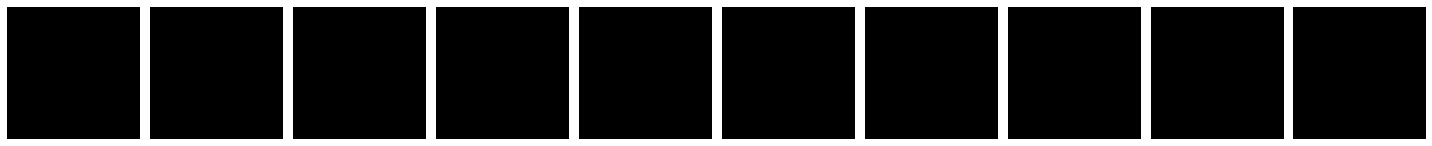

Epoch 48/100
547/547 - 26s - loss: 13.2921 - d_loss: 9.1886e-05 - g_loss: 13.2920


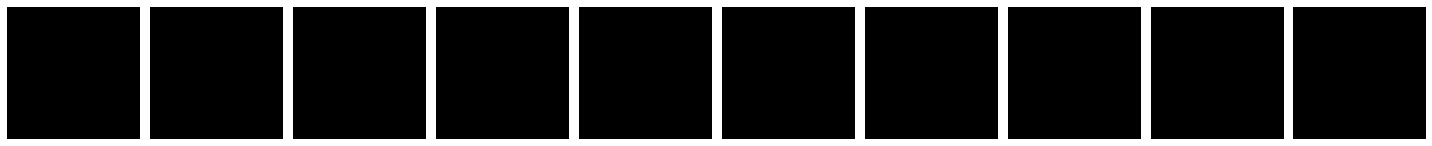

Epoch 49/100
547/547 - 26s - loss: 13.0036 - d_loss: 1.1730e-05 - g_loss: 13.0036


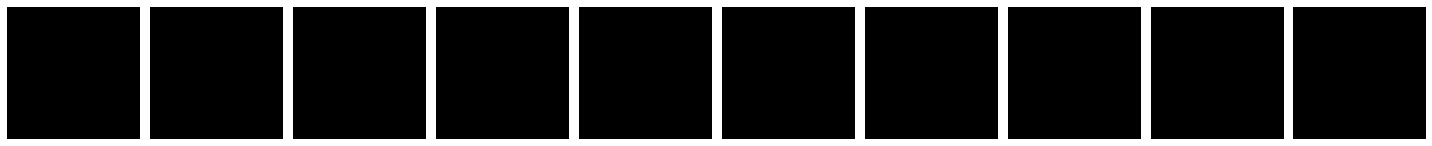

Epoch 50/100
547/547 - 26s - loss: 13.2657 - d_loss: 2.1014e-05 - g_loss: 13.2657


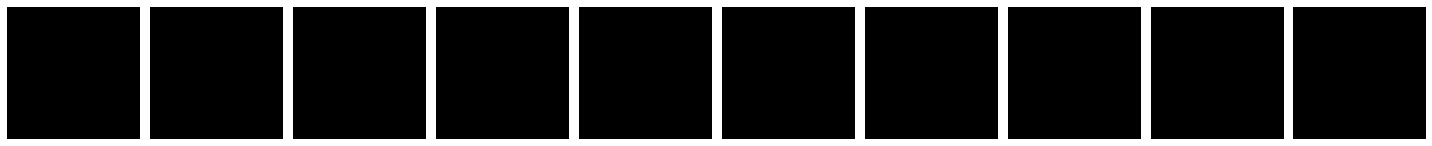

Epoch 51/100
547/547 - 26s - loss: 13.4884 - d_loss: 3.9758e-05 - g_loss: 13.4883


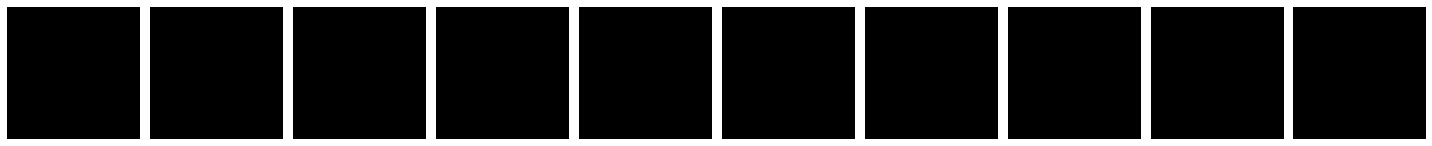

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f5d495697a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 52/100


KeyboardInterrupt: 

In [37]:
c_history = cgan.fit(
    dataset, 
    epochs = epochs, 
    callbacks = [ConditionalGANMonitor(name='conditional', gray=True)],
    verbose = 2
).history

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(c_history['loss'], label='GAN loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)
plt.show()

In [ ]:
cgan.generator.save('conditional_gan_generator')

In [ ]:
conditional_gan_generator = tfk.models.load_model('conditional_gan_generator')

In [ ]:
conditional_sample(conditional_gan_generator, 10, latent_dim, fixed=False, gray=True)
conditional_sample(conditional_gan_generator, 10, latent_dim, fixed=False, gray=True)

In [ ]:
imgs = 2500
X_hat, y_hat = generate_conditional_dataset(conditional_gan_generator, imgs, latent_dim)
X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))*127.5 + 127+5
X_hat = np.mean(X_hat, axis=0)
y_hat = np.argmax(y_hat,axis=1)

X_temp = X[:imgs]*127.5 + 127+5
X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
X_temp = np.mean(X_temp, axis=0)
y_temp = y[:imgs]

print(X_hat.shape, X_temp.shape)

In [ ]:
plt.figure(figsize=(10,4))
sns.kdeplot(x=X_hat, label='Sampled data', linewidth=3)
sns.kdeplot(x=X_temp, label='Real data', linewidth=3)
plt.legend()
plt.show()

In [ ]:
imgs = 1000
fig, axes = plt.subplots(2, 5, figsize=(28,12), sharey=True, sharex=True)
fig.suptitle('Classes pixels distributions')
for i in range(10):
    X_hat, y_hat = generate_conditional_dataset(conditional_gan_generator, imgs, latent_dim, label=i)
    X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))*127.5 + 127+5
    X_hat = np.mean(X_hat, axis=0)
    X_temp = X[y==i][:imgs]*127.5 + 127+5
    X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
    X_temp = np.mean(X_temp, axis=0)
    axes[i//5, i%5].set_title(f'Class {i}')
    sns.kdeplot(ax=axes[i//5, i%5], x=X_hat, label='Sampled data', linewidth=2)
    sns.kdeplot(ax=axes[i//5, i%5], x=X_temp, label='Real data', linewidth=2)
plt.legend()
plt.show()

In [ ]:
for i in range(num_classes):
    conditional_sample(conditional_gan_generator, 10, latent_dim, gray=True, fixed=False, label=i)

In [ ]:
# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 500  

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = tfk.utils.to_categorical([first_number], num_classes)
    second_label = tfk.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (first_label * (1 - percent_second_label) + second_label * percent_second_label)

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = conditional_gan_generator.predict(noise_and_labels, verbose=0)
    return fake


start_class = 0  
end_class = 1  

fake_images = interpolate_class(start_class, end_class)

In [ ]:
fake_images = interpolate_class(start_class, end_class)*127.5 + 127.5
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation01.gif", converted_images, fps=60)